# Library Import And Install

In [ ]:
import matplotlib
import numpy as np
import pandas as pd
import os
from scipy.io import loadmat
import random
import matplotlib.pyplot as plt 
import tensorflow as tf
from random import sample
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')
from sklearn.utils import class_weight
from collections import Counter
import sklearn


tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.7.0


In [ ]:
%pip install plotly --upgrade

In [ ]:
import plotly.express as px

In [ ]:
# Random seed for reproducibility
seed = 61

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Drive Mount & Path

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Prepare preprocessed data

In [ ]:
#@markdown ## Select dataset and training method:

window = "medium" #@param ["medium", "small", "both"] {type:"string"}

method = "2step" #@param ["2step", "bal", "under", "aug"] {type:"string"}


## Import preprocessed dataset

Notice: the notation in this script is UP since the upsampled dataset was previously used but this saturated RAM during training thus requiring a data generator, but this slowed down training. For these reasons and the consideration that we are not interested in frequency conted above 40 Hz, for which a sampling frequincy greater then the double is sufficient the downsampled dataset (128Hz) was preferred.

In [ ]:
freq=128 #sampling freq in Hz

### Import Data With Pickle

In [ ]:
import pickle 

### Downsampled training set

In [ ]:
if window == "small" or window == "both":
  #asymmetrical (small) window: -80;50 (numbers refer to the number of samples around the Rpeak considered for the window)
  with open("/content/drive/MyDrive/A.I/FinalProject/Dataset/NewDataset_128/trainDOWN_new.pickle","rb") as f:
    trainUPsmall=pickle.load(f)

In [ ]:
if window == "medium" or window == "both":
  #symmetrical medium sized window : 264 (total window size in number of samples, centered on the Rpeak position)
  with open("/content/drive/MyDrive/A.I/FinalProject/Dataset/avg_window_128_dataset/trainDOWN264.pickle","rb") as f:
    trainUP=pickle.load(f)

also a window of 476 samples was attempted in order to guarantee the presence of more than 2 Rpeeks around the central one (more than 1 per side) but this seemed proved to be a too noisy input with respect to the target for the models so both a small window containing only the Rpeak of the hearbeat to classify were attemped and a tradeoff window of 264 containing an R peak before and one after the R peak of the heartbeat to classify (this value was obtained by searching for convergence in max distance between R peaks); the idea is that morphological differences will be clearer when looking at a smaller window (QRS distorsion for PVC and P wave for PAC) while rhythm alterations will be more evident in wider windows (for both diseases)

### Training target

In [ ]:
with open("/content/drive/MyDrive/A.I/FinalProject/Dataset/NewDataset_128/y_train_new.pickle","rb") as f:
  ytrain=pickle.load(f)

### Downsampled validation set

In [ ]:
if window == "small" or window == "both":
  #asymmetrical (small) window: -80;50
  with open("/content/drive/MyDrive/A.I/FinalProject/Dataset/NewDataset_128/valDOWN_new.pickle","rb") as f:
    valUPsmall=pickle.load(f)

In [ ]:
if window == "medium" or window == "both":
  #symmetrical medium sized window : 264
  with open("/content/drive/MyDrive/A.I/FinalProject/Dataset/avg_window_128_dataset/valDOWN264.pickle","rb") as f:
    valUP=pickle.load(f)

### Validation target

In [ ]:
with open("/content/drive/MyDrive/A.I/FinalProject/Dataset/NewDataset_128/y_val_new.pickle","rb") as f:
  y_val=pickle.load(f)

### One Hot Train

In [ ]:
#one hot train
num_classes = 3
one_hot_labels = np.zeros((len(ytrain), 3), dtype=np.bool)

for i, single_label in enumerate (ytrain):
  for j, x in enumerate(['N','S','V']):
    if (x in single_label):
      one_hot_labels[i][j] = 1
one_hot_labels = one_hot_labels * 1.
print('training set shape %s' % Counter(ytrain)) 

training set shape Counter({'N': 170937, 'S': 7381, 'V': 5986})


In [ ]:
if window == "medium" or window == "both":
  trainUP[0]=np.asarray(trainUP[0])
  trainUP[1]=np.asarray(trainUP[1])
  samples= trainUP[0].shape[1] #number of samples in the window
  print(trainUP[0].shape)

(184304, 264)


In [ ]:
if window == "small" or window == "both":
  trainUPsmall[0]=np.asarray(trainUPsmall[0])
  trainUPsmall[1]=np.asarray(trainUPsmall[1])
  samples_small= trainUPsmall[0].shape[1]
  print(trainUPsmall[0].shape)

### One Hot Val

In [ ]:
#one hot val
num_classes = 3
one_hot_labelsV = np.zeros((len(y_val), 3), dtype=np.bool)

for i, single_label in enumerate (y_val):
  for j, x in enumerate(['N','S','V']):
    if (x in single_label):
      one_hot_labelsV[i][j] = 1
one_hot_labelsV = one_hot_labelsV * 1.

In [ ]:
if window == "medium" or window == "both":
  valUP[0]=np.asarray(valUP[0])
  valUP[1]=np.asarray(valUP[1])

In [ ]:
from collections import Counter 
print('validation set shape %s' % Counter(y_val)) 

validation set shape Counter({'N': 51619, 'S': 2228, 'V': 1807})


In [ ]:
if window == "small" or window == "both":
  valUPsmall[0]=np.asarray(valUPsmall[0])
  valUPsmall[1]=np.asarray(valUPsmall[1])

## Data undersampling
the idea was then to build an ensamble with the same model trained on all S and V samples but each time different N samples, but it was dropped for a better performing approach

In [ ]:
if method == "bal" or method == "under":
  trainUPpos=np.arange(0,len(trainUP[0]),1) #heartbeats' positions in the training set 
  print(trainUPpos)

In [ ]:
if method == "bal" or method == "under":
  #positions for each target class
  Npos=[]
  Spos=[]
  Vpos=[]
  for i in trainUPpos:
      if ytrain[i]=='N':
          Npos.append(i)
      elif ytrain[i]=='S':
          Spos.append(i)
      elif ytrain[i]=='V':
          Vpos.append(i)
  print(len(Npos), len(Spos), len(Vpos))

In [ ]:
if method == "bal" or method == "under":
  Npos_down = sample(Npos,k=len(Spos))
  N_down_prop=float(len(Npos_down))/(len(Npos_down)+len(Spos)+len(Vpos)) #to replicate undersampling proportions in the validation set
  print(len(Npos_down))

such is the disproportion between the majority class and the other 2 that even using balanced class weights the model still results biased towards the majority class since it is not given the chance to learn the minority classes befor oferfitting of the majority one occures

In [ ]:
if method == "bal" or method == "under":
  trainUPunder=[[],[]]
  yunder=[]
  for i in trainUPpos:
      for n in Npos_down:
          if (i == n):
              yunder.append(ytrain[i])
              trainUPunder[0].append(trainUP[0][i])
              trainUPunder[1].append(trainUP[1][i])
      for s in Spos:
          if (i == s):
              yunder.append(ytrain[i])
              trainUPunder[0].append(trainUP[0][i])
              trainUPunder[1].append(trainUP[1][i])
      for v in Vpos:
          if (i == v):
              yunder.append(ytrain[i])
              trainUPunder[0].append(trainUP[0][i])
              trainUPunder[1].append(trainUP[1][i])


In [ ]:
if method == "bal" or method == "under":
  #shuffle to feed the models samples from the different classes in random order
  c = list(zip(trainUPunder,yunder))
  random.shuffle(c)
  trainUPunder, yunder = zip(*c)
  print(len(trainUPunder[1]), len(yunder))

In [ ]:
if method == "bal" or method == "under":
  del c
  del trainUPpos
  del Npos
  del Spos
  del Vpos
  del Npos_down
  del one_hot_labels
  print('Resampled dataset shape %s' % Counter(yunder))

In [ ]:
if method == "bal" or method == "under":
  #one hot undersampled train
  num_classes = 3
  one_hot_labels = np.zeros((len(yunder), 3), dtype=np.bool)

  for i, single_label in enumerate (yunder):
    for j, x in enumerate(['N','S','V']):
      if (x in single_label):
        one_hot_labels[i][j] = 1
  one_hot_labels = one_hot_labels * 1.

  #for compatibility
  trainUPunder[0]=np.asarray(trainUPunder[0])
  trainUPunder[1]=np.asarray(trainUPunder[1])

#### undersample val set, only if method "under"

In [ ]:
if method == "under":
  valUPpos=np.arange(0,len(valUP[0]),1)
  print(valUPpos)

In [ ]:
if method == "under":
  Npos=[]
  Spos=[]
  Vpos=[]
  for i in valUPpos:
      if y_val[i]=='N':
          Npos.append(i)
      elif y_val[i]=='S':
          Spos.append(i)
      elif y_val[i]=='V':
          Vpos.append(i)
  print(len(Npos), len(Spos), len(Vpos))

In [ ]:
if method == "under":
  #just to check
  print('Original dataset shape %s' % Counter(y_val))  

In [ ]:
if method == "under":
  Npos_down = sample(Npos,k=int(float(len(y_val))*N_down_prop)) 
  print(len(Npos_down),N_down_prop)

in order to have a comparable loss between val and train during training undersample the val set with the same proportions as done for the training set and use that val_under for training, good for overfitting identification, and then use whole val to actually evaluate performance of obtained model (better simulation of how test data will be distributed). This is necessary since the class weights are computed with respect to the undersamples label distrinution in "under" method

In [ ]:
if method == "under":
  valUPunder=[[],[]]
  yunderV=[]
  for i in valUPpos:
      for n in Npos_down:
          if (i == n):
              yunderV.append(y_val[i])
              valUPunder[0].append(valUP[0][i])
              valUPunder[1].append(valUP[1][i])
      for s in Spos:
          if (i == s):
              yunderV.append(y_val[i])
              valUPunder[0].append(valUP[0][i])
              valUPunder[1].append(valUP[1][i])
      for v in Vpos:
          if (i == v):
              yunderV.append(y_val[i])
              valUPunder[0].append(valUP[0][i])
              valUPunder[1].append(valUP[1][i])

In [ ]:
#done since big validation sets mey need to be divided in batches, unbiased estimate for each one this way
if method == "under":
  c = list(zip(valUPunder[0],valUPunder[1],yunderV))
  random.shuffle(c)
  valUPunder[0], valUPunder[1],yunderV = zip(*c)

In [ ]:
if method == "under":
  del c
  print(len(valUPunder[1]), len(yunderV), len(valUPunder[0]))

In [ ]:
if method == "under":
  #just to check
  print('Resampled dataset shape %s' % Counter(yunderV))

In [ ]:
if method == "under":
  del valUPpos
  del Npos
  del Spos
  del Vpos
  del Npos_down

In [ ]:
if method == "under":
  #one hot undersampled validation
  num_classes = 3
  one_hot_labelsVunder = np.zeros((len(yunderV), 3), dtype=np.bool)

  for i, single_label in enumerate (yunderV):
    for j, x in enumerate(['N','S','V']):
      if (x in single_label):
        one_hot_labelsVunder[i][j] = 1
  one_hot_labelsVunder = one_hot_labelsVunder * 1.

  valUPunder[0]=np.asarray(valUPunder[0])
  valUPunder[1]=np.asarray(valUPunder[1])

## Balanced Loss
as already mentioned balanced loss with such an imbalance did not resolve the issue of models being biased to the majority class so the training set was undersampled and the validation one not, as customary but due to the difficulty of the task at hand this caused the train and val losses to not be comparable causing early stopping immediately so ("bal" method) the class weights were applyed also to the validation set (only during training) but since this maintained the original proportions the weights were given by them

In [ ]:
if method == "under":
  class_weights_alt = class_weight.compute_class_weight(
              class_weight='balanced', 
              classes=['N','S','V'],
              y=yunder)
  class_weights_alt = dict(enumerate(class_weights_alt))
  #for code compactness
  ytrain=yunder
  del yunder

if method == "bal" or "aug": #if aug this is just to obtain val weights
  class_weights_alt = class_weight.compute_class_weight(
              class_weight='balanced', 
              classes=['N','S','V'],
              y=ytrain)
  class_weights_alt = dict(enumerate(class_weights_alt))
if method == "bal": 
  #for code compactness
  ytrain=yunder
  del yunder

In [ ]:
if method == "bal" or method == "under" or method == "aug":
  print(class_weights_alt)

{0: 0.35939946686011026, 1: 8.323352752562887, 2: 10.263058247020826}


### Apply weights also to val set

In [ ]:
#particularly usefull since considereb by the weights metrics
if method == "bal" or method == "aug":
  samples_weights=np.empty(len(y_val))
  for i in range(len(y_val)):
      if y_val[i]=='N':
          samples_weights[i]=class_weights_alt[0]
      elif y_val[i]=='S':
          samples_weights[i]=class_weights_alt[1]
      elif y_val[i]=='V':
          samples_weights[i]=class_weights_alt[2]
  print(samples_weights, samples_weights.shape, len(y_val), len(samples_weights))

if method == "under":
  samples_weights=np.empty(len(yunderV))
  for i in range(len(yunderV)):
      if yunderV[i]=='N':
          samples_weights[i]=class_weights_alt[0]
      elif yunderV[i]=='S':
          samples_weights[i]=class_weights_alt[1]
      elif yunderV[i]=='V':
          samples_weights[i]=class_weights_alt[2]
  print(samples_weights, samples_weights.shape, len(yunderV), len(samples_weights))

[0.35939947 0.35939947 0.35939947 ... 0.35939947 0.35939947 0.35939947] (55654,) 55654 55654


## Balance dataset with undersampling and augmentation
to avoid losing too much information as for undersampling the balancing is done by augmenting the minority class in order to double it (invert the polarity) and do the same for part of the majority class (indipendent from the one left the same to maximize variability) and combine the 2 approaches for the middle class

In [ ]:
if method == "aug":
  trainUPpos=np.arange(0,len(trainUP[0]),1)
  print(trainUPpos)

[     0      1      2 ... 184301 184302 184303]


In [ ]:
if method == "aug":
  Npos=[]
  Spos=[]
  Vpos=[]
  for i in trainUPpos:
      if ytrain[i]=='N':
          Npos.append(i)
      elif ytrain[i]=='S':
          Spos.append(i)
      elif ytrain[i]=='V':
          Vpos.append(i)
  print(len(Npos), len(Spos), len(Vpos))

170937 7381 5986


In [ ]:
if method == "aug":  
  #just to check
  print('Original dataset shape %s' % Counter(ytrain)) 

Original dataset shape Counter({'N': 170937, 'S': 7381, 'V': 5986})


In [ ]:
if method == "aug":
  Npos = sample(Npos,k=len(Vpos)*2)
  print(len(Npos)) #mult by -1 only half of them

11972


In [ ]:
if method == "aug":
  #S pos: mult by -1 only from len(Vpos) onwards and also on 2*len(Vpos)-len(Spos) rand extractions from Spos[0:len(Vpos)] 
  Spos_re=sample(Spos[0:len(Vpos)],k=2*len(Vpos)-len(Spos))
  print(len(Spos_re))

4591


In [ ]:
if method == "aug":
  trainUPunder=[[],[]]
  yunder=[]
  for i in trainUPpos:
      for n in Npos:
          if (i == n):
              yunder.append(ytrain[i])
              if i<len(Vpos):
                  trainUPunder[0].append(trainUP[0][i])
                  trainUPunder[1].append(trainUP[1][i])
              else:
                  trainUPunder[0].append([-1*el for el in trainUP[0][i]])
                  trainUPunder[1].append([-1*el for el in trainUP[1][i]])

      for s in Spos:
          if (i == s):
              yunder.append(ytrain[i])
              trainUPunder[0].append(trainUP[0][i])
              trainUPunder[1].append(trainUP[1][i])

      for v in Vpos:
          if (i == v):
              yunder.append(ytrain[i])
              trainUPunder[0].append(trainUP[0][i])
              trainUPunder[1].append(trainUP[1][i])

      for sa in Spos_re:
          if (i == sa):
              yunder.append(ytrain[i])
              trainUPunder[0].append([-1*el for el in trainUP[0][i]])
              trainUPunder[1].append([-1*el for el in trainUP[1][i]])
      
      for va in Vpos: #duplicate Vpos and mult all by -1
          if (i == va):
              yunder.append(ytrain[i])
              trainUPunder[0].append([-1*el for el in trainUP[0][i]])
              trainUPunder[1].append([-1*el for el in trainUP[1][i]])

In [ ]:
if method == "aug" and window=="both": #trials with only the small window were dropped at this point since alone it was not informatie enough
  trainUPunder_small=[[],[]]
  for i in trainUPpos:
      for n in Npos:
          if (i == n):
              if i<len(Vpos):
                  trainUPunder_small[0].append(trainUPsmall[0][i])
                  trainUPunder_small[1].append(trainUPsmall[1][i])
              else:
                  trainUPunder_small[0].append([-1*el for el in trainUPsmall[0][i]])
                  trainUPunder_small[1].append([-1*el for el in trainUPsmall[1][i]])

      for s in Spos:
          if (i == s):
              trainUPunder_small[0].append(trainUPsmall[0][i])
              trainUPunder_small[1].append(trainUPsmall[1][i])

      for v in Vpos:
          if (i == v):
              trainUPunder_small[0].append(trainUPsmall[0][i])
              trainUPunder_small[1].append(trainUPsmall[1][i])

      for sa in Spos_re:
          if (i == sa):
              trainUPunder_small[0].append([-1*el for el in trainUPsmall[0][i]])
              trainUPunder_small[1].append([-1*el for el in trainUPsmall[1][i]])
      
      for va in Vpos:
          if (i == va):
              trainUPunder_small[0].append([-1*el for el in trainUPsmall[0][i]])
              trainUPunder_small[1].append([-1*el for el in trainUPsmall[1][i]])

  c = list(zip(trainUPunder[0],trainUPunder[1],yunder, trainUPunder_small[0],trainUPunder_small[1])) #shuffle all together to maintain matching heartbeats and labels

  random.shuffle(c)

  trainUPunder[0], trainUPunder[1], yunder, trainUPunder_small[0], trainUPunder_small[1] = zip(*c)

  trainUPunder_small=list(trainUPunder_small)

  trainUPunder_small[0]=np.asarray(trainUPunder_small[0])
  trainUPunder_small[1]=np.asarray(trainUPunder_small[1])

  print(len(trainUPunder_small), len(trainUPunder_small[0]), len(trainUPunder_small[1]))

2 35916 35916


In [ ]:
if window == "medium" and method == "aug":
  c = list(zip(trainUPunder[0],trainUPunder[1],yunder))

  random.shuffle(c)

  trainUPunder[0], trainUPunder[1], yunder = zip(*c)

  print(len(trainUPunder), len(yunder), len(trainUPunder[0]), len(trainUPunder[1]))

In [ ]:
if method == "aug":
  del c
  del trainUPpos
  del Npos
  del Spos
  del Vpos
  del Spos_re
  del one_hot_labels
  print('Resampled dataset shape %s' % Counter(yunder))

Resampled dataset shape Counter({'N': 11972, 'V': 11972, 'S': 11972})


In [ ]:
#one hot train resampled
if method == "aug":
  num_classes = 3
  one_hot_labels = np.zeros((len(yunder), 3), dtype=np.bool)

  for i, single_label in enumerate (yunder):
    for j, x in enumerate(['N','S','V']):
      if (x in single_label):
        one_hot_labels[i][j] = 1
  one_hot_labels = one_hot_labels * 1.

  trainUPunder[0]=np.asarray(trainUPunder[0])
  trainUPunder[1]=np.asarray(trainUPunder[1])
  
  ytrain=yunder

  del yunder

## 2 Step classification
use network to classify normal heartbeats and ones with disease and then feed the heartbeats with disease to a second network which classifies PAC or PVC; this approach allows both networks to be more balanced than before, specially the second one, the first one is still greatly inbalanced but in this case class weights proved to be sufficient

In [ ]:
if method == "2step":
  #shuffle val set once and for all
  c = list(zip(valUP[0], valUP[1],y_val))

  random.shuffle(c)

  valUP[0], valUP[1],y_val = zip(*c) 

In [ ]:
if method == "2step": #repeat for coherence with shuffling
  #one hot val 
  num_classes = 3
  one_hot_labelsV = np.zeros((len(y_val), 3), dtype=np.bool)

  for i, single_label in enumerate (y_val):
    for j, x in enumerate(['N','S','V']):
      if (x in single_label):
        one_hot_labelsV[i][j] = 1
  one_hot_labelsV = one_hot_labelsV * 1.

In [ ]:
if method == "2step":
  del c

In [ ]:
if method == "2step":
  #one hot val
  num_classes = 3
  one_hot_labelsV = np.zeros((len(y_val), 3), dtype=np.bool)

  for i, single_label in enumerate (y_val):
    for j, x in enumerate(['N','S','V']):
      if (x in single_label):
        one_hot_labelsV[i][j] = 1
  one_hot_labelsV = one_hot_labelsV * 1.

### Step 1

In [ ]:
if method == "2step":
  ytrain_health=np.empty(len(ytrain),dtype=np.str)
  for i,label in enumerate(ytrain):
    if label=='N':
      ytrain_health[i]=label
    if (label=='S') or (label =='V'):
      ytrain_health[i]='D' #disease
  print(len(ytrain_health))

184304


In [ ]:
if method == "2step":
  c = list(zip(trainUP[0], trainUP[1],ytrain_health, ytrain))

  random.shuffle(c)
  
  trainUP[0], trainUP[1],ytrain_health, ytrain = zip(*c)

In [ ]:
if method == "2step": #since for coherence ytrain is also shuffled one hot encoding must be adapted to the new order
  num_classes = 3
  one_hot_labels = np.zeros((len(ytrain), 3), dtype=np.bool)

  for i, single_label in enumerate (ytrain):
    for j, x in enumerate(['N','S','V']):
      if (x in single_label):
        one_hot_labels[i][j] = 1
  one_hot_labels = one_hot_labels * 1.
  print('training set shape %s' % Counter(ytrain)) 

training set shape Counter({'N': 170937, 'S': 7381, 'V': 5986})


In [ ]:
if method == "2step":
  del c
  print(Counter(ytrain_health)) #still more than 10:1 imbalance

Counter({'N': 170937, 'D': 13367})


In [ ]:
if method == "2step":
  #one hot train health
  num_classes = 2
  one_hot_labelsH = np.zeros((len(ytrain_health), 2), dtype=np.bool)

  for i, single_label in enumerate (ytrain_health):
    for j, x in enumerate(['N','D']):
      if (x in single_label):
        one_hot_labelsH[i][j] = 1
  one_hot_labelsH = one_hot_labelsH * 1.

In [ ]:
if method == "2step":
  yval_health=np.empty(len(y_val),dtype=np.str)
  for i,label in enumerate(y_val):
    if label=='N':
      yval_health[i]=label
    if (label=='S') or (label =='V'):
      yval_health[i]='D' #disease
  print(len(yval_health))

55654


In [ ]:
if method == "2step":
  print(Counter(yval_health))

Counter({'N': 51619, 'D': 4035})


In [ ]:
if method == "2step":
  #one hot val health
  num_classes = 2
  one_hot_labelsVH = np.zeros((len(yval_health), 2), dtype=np.bool)

  for i, single_label in enumerate (yval_health):
    for j, x in enumerate(['N','D']):
      if (x in single_label):
        one_hot_labelsVH[i][j] = 1
  one_hot_labelsVH = one_hot_labelsVH * 1.

#### Balanced loss (for step1)

In [ ]:
if method == "2step":
  class_weights_H = class_weight.compute_class_weight(
              class_weight='balanced', 
              classes=['N','D'],
              y=ytrain_health)
  class_weights_H = dict(enumerate(class_weights_H))
  print(class_weights_H)

{0: 0.5390992002901653, 1: 6.893992668512007}


In [ ]:
if method == "2step":
  #for val for use of weighted metrics and better comparison with training 
  samples_weightsH=np.empty(len(yval_health))
  for i in range(len(yval_health)):
      if yval_health[i]=='N':
          samples_weightsH[i]=class_weights_H[0]
      elif yval_health[i]=='D':
          samples_weightsH[i]=class_weights_H[1]
  print(samples_weightsH.shape, np.unique(samples_weightsH))

(55654,) [0.5390992  6.89399267]


### Step 2

In [ ]:
if method == "2step":
  trainUPpos=np.arange(0,len(trainUP[0]),1)
  print(trainUPpos)

[     0      1      2 ... 184301 184302 184303]


In [ ]:
if method == "2step":
  Spos=[]
  Vpos=[]
  for i in trainUPpos:
      if ytrain[i]=='S':
          Spos.append(i)
      elif ytrain[i]=='V':
          Vpos.append(i)
  print(len(Spos), len(Vpos))


7381 5986


In [ ]:
from tqdm.auto import tqdm
if method == "2step":
  pos_all = Spos+Vpos
  pos_all.sort()
  
  trainSV=[[],[]]
  ytrainSV=[]
  for i in tqdm(pos_all):
            ytrainSV.append(ytrain[i])
            trainSV[0].append(trainUP[0][i])
            trainSV[1].append(trainUP[1][i])
  trainSV=list(trainSV)
  print(len(trainSV[1]), len(ytrainSV))

  0%|          | 0/13367 [00:00<?, ?it/s]

13367 13367


In [ ]:
if method == "2step":
  del trainUPpos
  del Spos
  del Vpos
  #just to check
  print('PAC/PVC dataset shape %s' % Counter(ytrainSV))
  print(len(trainSV[1]), len(ytrainSV))

PAC/PVC dataset shape Counter({'S': 7381, 'V': 5986})
13367 13367


In [ ]:
if method == "2step":
  #one hot train
  num_classes = 2
  one_hot_labelsSV = np.zeros((len(ytrainSV), 2), dtype=np.bool)

  for i, single_label in enumerate (ytrainSV):
    for j, x in enumerate(['S','V']):
      if (x in single_label):
        one_hot_labelsSV[i][j] = 1
  one_hot_labelsSV = one_hot_labelsSV * 1.
  trainSV[0]=np.asarray(trainSV[0])
  trainSV[1]=np.asarray(trainSV[1])

#### Validation SV

In [ ]:
if method == "2step":
  valUPpos=np.arange(0,len(valUP[0]),1)
  print(valUPpos)

[    0     1     2 ... 55651 55652 55653]


In [ ]:
if method == "2step":
  Spos=[]
  Vpos=[]
  for i in valUPpos:
      if y_val[i]=='S':
          Spos.append(i)
      elif y_val[i]=='V':
          Vpos.append(i)
  print(len(Spos), len(Vpos))

2228 1807


In [ ]:
from tqdm.auto import tqdm
if method == "2step":
  pos_all = Spos+Vpos
  pos_all.sort()
  
  valSV=[[],[]]
  y_valSV=[]
  for i in tqdm(pos_all):
            y_valSV.append(y_val[i])
            valSV[0].append(valUP[0][i])
            valSV[1].append(valUP[1][i])
  valSV=list(valSV)
  print(len(valSV[1]), len(valSV))

  0%|          | 0/4035 [00:00<?, ?it/s]

4035 2


In [ ]:
if method == "2step":
  del valUPpos
  del Spos
  del Vpos
  #just to check
  print('validation SV dataset shape %s' % Counter(y_valSV))

validation SV dataset shape Counter({'S': 2228, 'V': 1807})


In [ ]:
if method == "2step":
  #one hot val
  num_classes = 2
  one_hot_labelsVSV = np.zeros((len(y_valSV), 2), dtype=np.bool)

  for i, single_label in enumerate (y_valSV):
    for j, x in enumerate(['S','V']):
      if (x in single_label):
        one_hot_labelsVSV[i][j] = 1
  one_hot_labelsVSV = one_hot_labelsVSV * 1.
  valSV[0]=np.asarray(valSV[0])
  valSV[1]=np.asarray(valSV[1])

#### Balanced loss (step2)

In [ ]:
if method == "2step":
  class_weights_SV = class_weight.compute_class_weight(
              class_weight='balanced', 
              classes=['S','V'],
              y=ytrainSV)
  class_weights_SV = dict(enumerate(class_weights_SV))
  print(class_weights_SV)

{0: 0.905500609673486, 1: 1.1165218843969262}


In [ ]:
if method == "2step":
  #for val
  samples_weightsSV=np.empty(len(y_valSV))
  for i in range(len(y_valSV)):
      if y_valSV[i]=='S':
          samples_weightsSV[i]=class_weights_SV[0]
      elif y_valSV[i]=='V':
          samples_weightsSV[i]=class_weights_SV[1]
  print(np.unique(samples_weightsSV), samples_weightsSV.shape)

[0.90550061 1.11652188] (4035,)


## Metrics

In [ ]:
from keras import backend as K

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, f1_score, cohen_kappa_score

In [ ]:
def plot_CMatrix(matrix,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import itertools
    plt.close
    accuracy = np.trace(matrix) / float(np.sum(matrix))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]


    thresh = matrix.max() / 1.5 if normalize else matrix.max() / 2
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(matrix[i, j]),
                     horizontalalignment="center",
                     color="black" if matrix[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(matrix[i, j]),
                     horizontalalignment="center",
                     color="black" if matrix[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.grid(False)
    plt.show()

In [ ]:
def bal_acc(y_true, y_pred):
  # 1) Numpy Conversion )(not required if done on predictions)
  true = y_true #.numpy() only if used in keras model (tensors)
  pred = y_pred #as above
  # 1b) From probability to int
  true = np.round(true)
  pred = np.round(pred)

  # 2) Extract the number of beats for each class
  true_N = true[:,0]
  true_S = true[:,1]
  true_V = true[:,2]
  n_N = np.count_nonzero(true_N, axis=0)
  n_S = np.count_nonzero(true_S, axis=0)
  n_V = np.count_nonzero(true_V, axis=0)

  # Compute the total number of beats in the batch
  #print("n_N:", n_N,"n_S:", n_S,"n_V:", n_V)
  #totSample = n_N + n_V + n_S

  # 3) Compute the majority class
  max_class = [n_N, n_S, n_V]
  max_class.sort()
  #print("max_class:", max_class[-1])

  # 4) Compute the weights for the balanced mean (max_class + beats per class)
  if n_N != 0 and n_S != 0 and n_V != 0:
    wN = max_class[-1]/n_N
    wS = max_class[-1]/n_S
    wV = max_class[-1]/n_V

    # 5) Compute True Positive Number
    # Slice the predictor in  the different classes
    pred_N = pred[:,0]
    pred_S = pred[:,1]
    pred_V = pred[:,2]

    # Compute True Positive
    tp_N = np.count_nonzero(true_N*pred_N, axis=0)
    tp_S = np.count_nonzero(true_S*pred_S, axis=0)
    tp_V = np.count_nonzero(true_V*pred_V, axis=0)

    # 6) balanced Accuracy
    #print(" - N:", tp_N/n_N, "S:", tp_V/n_V, "V:", tp_S/n_S)
    #print(" --> wN:", wN,"wS:", wS,"wV:", wV)
    return(((tp_N/n_N)*wN + (tp_S/n_S)*wS + (tp_V/n_V)*wV) / (wN + wS + wV))

  elif n_S != 0 and n_V == 0:
    wN = max_class[-1]/n_N
    wS = max_class[-1]/n_S

    # 5) Compute True Positive Number
    # Slice the predictor in  the different classes
    pred_N = pred[:,0]
    pred_S = pred[:,1]

    # Compute True Positive
    tp_N = np.count_nonzero(true_N*pred_N, axis=0)
    tp_S = np.count_nonzero(true_S*pred_S, axis=0)

    # 6) balanced Accuracy
    #print(" - N:", tp_N/n_N,"S:", tp_S/n_S)
    #print(" --> wN:", wN,"wS:", wS)
    return(((tp_N/n_N)*wN + (tp_S/n_S)*wS) / (wN + wS))

  elif n_S == 0 and n_V != 0:
    wN = max_class[-1]/n_N
    wV = max_class[-1]/n_V

    # 5) Compute True Positive Number
    # Slice the predictor in  the different classes
    pred_N = pred[:,0]
    pred_V = pred[:,2]

    # Compute True Positive
    tp_N = np.count_nonzero(true_N*pred_N, axis=0)
    tp_V = np.count_nonzero(true_V*pred_V, axis=0)

    # 6) balanced Accuracy
    #print(" - N:", tp_N/n_N,"V:", tp_V/n_V)
    #print(" --> wN:", wN,"wV:", wV)
    return(((tp_N/n_N)*wN + (tp_V/n_V)*wV) / (wN + wV))

  elif n_S == 0 and n_V == 0:
    # 5) Compute True Positive Number
    # Slice the predictor in  the different classes
    pred_N = pred[:,0]

    # Compute True Positive
    tp_N = np.count_nonzero(true_N*pred_N, axis=0)

    # 6) balanced Accuracy
    #print(" - N:", tp_N/n_N,)
    return(tp_N/n_N)

In [ ]:
def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    #f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

In [ ]:
def ht(y_true, y_pred):
  #pred = y_pred.numpy()
  #pred = np.round(pred) #not required if done on predictions
  gamma =  0.00000001
  y_true = np.argmax(y_true, axis=1)
  y_pred = np.argmax(y_pred, axis=1)

  matrix = confusion_matrix(y_true, y_pred)
  #print("\n\nComplete Matrix")
  #print(matrix)
  #pred_A = pred[:,0]
  #pred_B = pred[:,1]
  #pred_C = pred[:,2]

  #n_A = np.count_nonzero(pred_N, axis=0)
  #n_B = np.count_nonzero(pred_S, axis=0)
  #n_C = np.count_nonzero(pred_V, axis=0)

  if(matrix.shape[0]==2):
    if(matrix[0,0]==0 and matrix[0,1]==0):
      #print("only second row")
      b = matrix[1,1]/(matrix[1,0]+matrix[1,1])
      return(b)

    elif(matrix[1,1]==0 and matrix[1,0]==0):
      #print("only first row")
      a = matrix[0,0]/(matrix[0,0]+matrix[0,1])
      return(a)

    else:
      #print("both")
      a = matrix[0,0]/(matrix[0,0]+matrix[0,1])
      b = matrix[1,1]/(matrix[1,0]+matrix[1,1])
      return(2/((1/(a+gamma))+(1/(b+gamma))))

  elif(matrix.shape[0]==3):
    first_row_0 = (matrix[0,0]==0 and matrix[0,1]==0  and matrix[0,2]==0)
    second_row_0 = (matrix[1,0]==0 and matrix[1,1]==0  and matrix[1,2]==0)
    third_row_0 = (matrix[2,0]==0 and matrix[2,1]==0  and matrix[2,2]==0)

    if(first_row_0 and second_row_0):
      #print("only third row")
      c = matrix[2,2]/(matrix[2,0]+matrix[2,1]+matrix[2,2])
      return(c)
    elif(first_row_0 and third_row_0):
      #print("only second row")
      c = matrix[1,1]/(matrix[1,0]+matrix[1,1]+matrix[1,2])
      return(c)
    elif(second_row_0 and third_row_0):
      #print("only first row")
      c = matrix[0,0]/(matrix[0,0]+matrix[0,1]+matrix[0,2])
      return(c)

    elif(first_row_0):
      #print("only second and third row")
      b = matrix[1,1]/(matrix[1,0]+matrix[1,1]+matrix[1,2])
      c = matrix[2,2]/(matrix[2,0]+matrix[2,1]+matrix[2,2])
      return(2/((1/(b+gamma))+(1/(c+gamma))))  
    elif(second_row_0):
      #print("only first and third row")
      a = matrix[0,0]/(matrix[0,0]+matrix[0,1]+matrix[0,2])
      c = matrix[2,2]/(matrix[2,0]+matrix[2,1]+matrix[2,2])
      return(2/((1/(a+gamma))+(1/(c+gamma))))
    elif(third_row_0):
      #print("only first and second row")
      a = matrix[0,0]/(matrix[0,0]+matrix[0,1]+matrix[0,2])
      b = matrix[1,1]/(matrix[1,0]+matrix[1,1]+matrix[1,2])
      return(2/((1/(a+gamma))+(1/(b+gamma))))

    else:
      #print("all")
      a = matrix[0,0]/(matrix[0,0]+matrix[0,1]+matrix[0,2])
      b = matrix[1,1]/(matrix[1,0]+matrix[1,1]+matrix[1,2])
      c = matrix[2,2]/(matrix[2,0]+matrix[2,1]+matrix[2,2])
      return(3/((1/(a+gamma))+(1/(b+gamma))+(1/(c+gamma))))

  else:
    return(matrix[0,0])

In [ ]:
def performancePlot(tr_data, start_epoch, model_name, show=True, save = False, folder = "/" ): #this, as other metrics not presented as outputs 
    #Plot the training and validation data 
    tbacc=tr_data['bal_acc']
    tloss=tr_data['loss']
    vbacc=tr_data['val_bal_acc']
    vloss=tr_data['val_loss']
    tf1= tr_data['f1']
    vf1= tr_data['val_f1']
    lr=tr_data['lr']
    tacc=tr_data['accuracy']
    vacc=tr_data['val_accuracy']

    Epoch_count=len(tloss)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_bacc=np.argmax(vbacc)
    bacc_highest=vbacc[index_bacc]
    index_f1=np.argmax(vf1)
    f1_highest=vf1[index_f1]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]

    plt.style.use('seaborn-darkgrid')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch) + "\nBest Loss= " + str(round(val_lowest,4))
    vc_label='best epoch= '+ str(index_bacc + 1+ start_epoch) + "\nBest Bal. Acc= " + str(round(bacc_highest,4))
    fc_label='best epoch= '+ str(index_f1 + 1+ start_epoch) + "\nBest Bal. Acc= " + str(round(f1_highest,4))
    vac_label='best epoch= '+ str(index_acc + 1+ start_epoch) + "\nBest Acc= " + str(round(acc_highest,4))
    fig,axes=plt.subplots(nrows=1, ncols=5, figsize=(24,8), gridspec_kw={'width_ratios': [3, 3, 3, 2,3]})
    # Set the graph titles
    st = fig.suptitle(model_name, fontsize="x-large", fontweight="bold")
    axes[0].plot(Epochs, tloss, linewidth=1.5,  label='Tr loss', marker='o', markersize=5)
    axes[0].plot(Epochs, vloss, linewidth=1.5,  label='Val loss', marker='o', markersize=5)
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=50, c= 'blue', marker='d', label=sc_label,  zorder = 10)
    axes[0].set_title('Tr and Val Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    
    axes[1].plot (Epochs, tbacc, linewidth=1.5, label= 'Tr Bal.Acc', marker='o', markersize=5)
    axes[1].plot (Epochs, vbacc, linewidth=1.5, label= 'Val Bal.Acc', marker='o', markersize=5)
    axes[1].scatter(index_bacc+1 +start_epoch,bacc_highest, s=50, c= 'blue', marker='d', label=vc_label,  zorder = 10)
    axes[1].set_title('Tr and Val Bal Acc')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Bal Acc Cohen Score')
    axes[1].legend()

    axes[2].plot (Epochs, tf1, linewidth=1.5, label= 'Tr f1', marker='o', markersize=5)
    axes[2].plot (Epochs, vf1, linewidth=1.5, label= 'Val f1', marker='o', markersize=5)
    axes[2].scatter(index_f1+1 +start_epoch,f1_highest, s=50, c= 'blue', marker='d', label=fc_label,  zorder = 10)
    axes[2].set_title('Training and Validation f1 score')
    axes[2].set_xlabel('Epochs')
    axes[2].set_ylabel('f1 score')
    axes[2].legend()

    axes[3].plot (Epochs, lr, linewidth=1.5, label= 'Learning Rate', marker='o', markersize=5)
    axes[3].set_title('Learning Rate')
    axes[3].set_xlabel('Epochs')
    axes[3].set_ylabel('Learning Rate')
    axes[3].legend()

    axes[4].plot (Epochs, tacc, linewidth=1.5, label= 'Tr Acc', marker='o', markersize=5)
    axes[4].plot (Epochs, vacc, linewidth=1.5, label= 'Val Acc', marker='o', markersize=5)
    axes[4].scatter(index_acc+1 +start_epoch,acc_highest, s=50, c= 'blue', marker='d', label=vac_label,  zorder = 10)
    axes[4].set_title('Accuracy')
    axes[4].set_xlabel('Epochs')
    axes[4].set_ylabel('Accuracy')
    axes[4].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    
    # Save should be before plot to avoid blank images
    if save:
      plt.savefig(str(folder + "/" + model_name + ".png"))
    if show:
      plt.show()

In [ ]:
def performancePlot_no_f1(tr_data, start_epoch, model_name, show=True, save = False, folder = "/" ):
    #Plot the training and validation data
    tbacc=tr_data['bal_acc']
    tloss=tr_data['loss']
    vbacc=tr_data['val_bal_acc']
    vloss=tr_data['val_loss']
    lr=tr_data['lr']
    tacc=tr_data['accuracy']
    vacc=tr_data['val_accuracy']

    Epoch_count=len(tloss)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_bacc=np.argmax(vbacc)
    bacc_highest=vbacc[index_bacc]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]

    plt.style.use('seaborn-darkgrid')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch) + "\nBest Loss= " + str(round(val_lowest,4))
    vc_label='best epoch= '+ str(index_bacc + 1+ start_epoch) + "\nBest Bal. Acc= " + str(round(bacc_highest,4))
    vac_label='best epoch= '+ str(index_acc + 1+ start_epoch) + "\nBest Acc= " + str(round(acc_highest,4))
    fig,axes=plt.subplots(nrows=1, ncols=4, figsize=(24,8), gridspec_kw={'width_ratios': [3, 3, 2, 3]})
    # Set the graph titles
    st = fig.suptitle(model_name, fontsize="x-large", fontweight="bold")
    axes[0].plot(Epochs, tloss, linewidth=1.5,  label='Training loss', marker='o', markersize=5)
    axes[0].plot(Epochs, vloss, linewidth=1.5,  label='Validation loss', marker='o', markersize=5)
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=50, c= 'blue', marker='d', label=sc_label,  zorder = 10)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    
    axes[1].plot (Epochs, tbacc, linewidth=1.5, label= 'Training Bal.Acc score', marker='o', markersize=5)
    axes[1].plot (Epochs, vbacc, linewidth=1.5, label= 'Validation Bal.Acc score', marker='o', markersize=5)
    axes[1].scatter(index_bacc+1 +start_epoch,bacc_highest, s=50, c= 'blue', marker='d', label=vc_label,  zorder = 10)
    axes[1].set_title('Training and Validation Balanced Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Balanced Accuracy Cohen Score')
    axes[1].legend()

    axes[2].plot (Epochs, lr, linewidth=1.5, label= 'Learning Rate', marker='o', markersize=5)
    axes[2].set_title('Learning Rate')
    axes[2].set_xlabel('Epochs')
    axes[2].set_ylabel('Learning Rate')
    axes[2].legend()

    axes[3].plot (Epochs, tacc, linewidth=1.5, label= 'Training Accuracy', marker='o', markersize=5)
    axes[3].plot (Epochs, vacc, linewidth=1.5, label= 'Validation Accuracy', marker='o', markersize=5)
    axes[3].scatter(index_acc+1 +start_epoch,acc_highest, s=50, c= 'blue', marker='d', label=vac_label,  zorder = 10)
    axes[3].set_title('Accuracy')
    axes[3].set_xlabel('Epochs')
    axes[3].set_ylabel('Accuracy')
    axes[3].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    
    # Save should be before plot to avoid blank images
    if save:
      plt.savefig(str(folder + "/" + model_name + ".png"))
    if show:
      plt.show()

In [ ]:
def performancePlot_2acc(tr_data, start_epoch, model_name, show=True, save = False, folder = "/" ):
    #Plot the training and validation data
    
    tloss=tr_data['loss']
    
    vloss=tr_data['val_loss']
    tf1= tr_data['weighted_accuracy']
    vf1= tr_data['val_weighted_accuracy']
    lr=tr_data['lr']
    tacc=tr_data['accuracy']
    vacc=tr_data['val_accuracy']

    Epoch_count=len(tloss)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    
    index_f1=np.argmax(vf1)
    f1_highest=vf1[index_f1]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]

    plt.style.use('seaborn-darkgrid')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch) + "\nBest Loss= " + str(round(val_lowest,4))
    
    fc_label='best epoch= '+ str(index_f1 + 1+ start_epoch) + "\nBest Bal. Acc= " + str(round(f1_highest,4))
    vac_label='best epoch= '+ str(index_acc + 1+ start_epoch) + "\nBest Acc= " + str(round(acc_highest,4))
    fig,axes=plt.subplots(nrows=1, ncols=4, figsize=(24,8), gridspec_kw={'width_ratios': [3, 3, 3,2]})
    # Set the graph titles
    st = fig.suptitle(model_name, fontsize="x-large", fontweight="bold")
    axes[0].plot(Epochs, tloss, linewidth=1.5,  label='Tr loss', marker='o', markersize=5)
    axes[0].plot(Epochs, vloss, linewidth=1.5,  label='Val loss', marker='o', markersize=5)
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=50, c= 'blue', marker='d', label=sc_label,  zorder = 10)
    axes[0].set_title('Tr and Val Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    
    axes[1].plot (Epochs, tacc, linewidth=1.5, label= 'Tr Acc', marker='o', markersize=5)
    axes[1].plot (Epochs, vacc, linewidth=1.5, label= 'Val Acc', marker='o', markersize=5)
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=50, c= 'blue', marker='d', label=vac_label,  zorder = 10)
    axes[1].set_title('Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()

    axes[2].plot (Epochs, tf1, linewidth=1.5, label= 'Tr w acc', marker='o', markersize=5)
    axes[2].plot (Epochs, vf1, linewidth=1.5, label= 'Val w acc', marker='o', markersize=5)
    axes[2].scatter(index_f1+1 +start_epoch,f1_highest, s=50, c= 'blue', marker='d', label=fc_label,  zorder = 10)
    axes[2].set_title('Training and Validation w acc')
    axes[2].set_xlabel('Epochs')
    axes[2].set_ylabel('w acc')
    axes[2].legend()

    axes[3].plot (Epochs, lr, linewidth=1.5, label= 'Learning Rate', marker='o', markersize=5)
    axes[3].set_title('Learning Rate')
    axes[3].set_xlabel('Epochs')
    axes[3].set_ylabel('Learning Rate')
    axes[3].legend()

    
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    
    # Save should be before plot to avoid blank images
    if save:
      plt.savefig(str(folder + "/" + model_name + ".png"))
    if show:
      plt.show()

## Callbacks

In [ ]:
exps_dir="/content/drive/MyDrive/A.I/FinalProject/modelSEBA/models"

def create_folders_and_callbacks(model_name):

  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = [
                #tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
                #tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.5, min_lr=1e-5)
                tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True), 
                tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=10, factor=0.5, min_lr=1e-5)
              ]

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=True,  # True to save only the best epoch
                                                     monitor='val_accuracy',
                                                     mode='max') 
  callbacks.append(ckpt_callback)


  return (callbacks, exp_dir)

In [ ]:
def create_folders_and_callbacks_imb(model_name):

  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = [
                #tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
                #tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.5, min_lr=1e-5)
                tfk.callbacks.EarlyStopping(monitor='val_weighted_accuracy', mode='max', patience=10, restore_best_weights=True), 
                tfk.callbacks.ReduceLROnPlateau(monitor='val_weighted_accuracy', mode='max', patience=10, factor=0.5, min_lr=1e-5) 
              ]

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=True,  # True to save only the best epoch
                                                     monitor='val_weighted_accuracy',
                                                     mode='max') 
  callbacks.append(ckpt_callback)


  return (callbacks, exp_dir)

  

## Models

In [ ]:
if method != "2step": 
  classes=3
if window == "medium":
  input_shape=(samples,2)
if window == "small":
  input_shape=(samples_small,2)

### LSTM classifier

In [ ]:
my_model_name = "LSTM_classifier264"
def build_LSTM_classifier(input_shape, classes):
    
    input_layer = tfkl.Input(shape=input_shape)
    
    units1=128
    drop=0.4
    reg='l2'
    r_reg='l2'
    filters1=128
    size1=3

    #tryed with and without attention, hierarchical LSTM and not; hyperperameters optimized to reduce overfitting and increase performance 
    
    seq, state_h, state = tfkl.LSTM(units1, return_sequences=True, return_state=True, dropout=drop, kernel_regularizer=reg, recurrent_regularizer=r_reg)(input_layer)

    attention = tfkl.Attention()([seq, tf.expand_dims(state,1)])

    convlstm = tfkl.Conv1D(filters1, size1, padding='same', activation='relu',kernel_regularizer=reg)(attention)
    convlstm = tfkl.MaxPool1D(2)(convlstm)
    dropout = tfkl.Dropout(0.5, seed=seed)(convlstm) #0.4
    flat= tfkl.GlobalMaxPooling1D()(dropout)

    classifier = tfkl.Dense(64, activation='relu')(flat)
    
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.categorical_crossentropy, optimizer=tfk.optimizers.Adam(), metrics=['accuracy',bal_acc,f1],run_eagerly=True)

    # Return the model
    return model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 264, 2)]     0           []                               
                                                                                                  
 lstm_1 (LSTM)                  [(None, 264, 128),   67072       ['input_2[0][0]']                
                                 (None, 128),                                                     
                                 (None, 128)]                                                     
                                                                                                  
 tf.expand_dims_1 (TFOpLambda)  (None, 1, 128)       0           ['lstm_1[0][2]']                 
                                                                                              

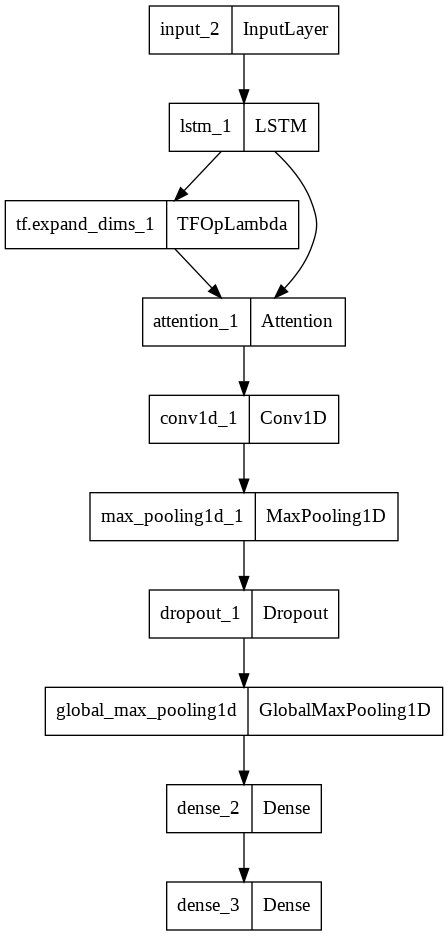

In [ ]:
model = build_LSTM_classifier(input_shape,classes)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

In [ ]:
my_model_name = "BiLSTM_classifier264"
def build_BiLSTM_classifier(input_shape, classes):  
    #l2 reg added to improve stability in training and other dense layer to increase complexity (this improved performances w.r.t. the previous model)

    input_layer = tfkl.Input(shape=input_shape, name='Input')
    drop=0.3
    reg='l2'
    r_reg='l2'
    units=64
    filters1=32
    size1=3

    seq, forward_state_h, forward_state, backward_state_h, backward_state = tfkl.Bidirectional(tfkl.LSTM(units, return_sequences=True, return_state=True,dropout=drop, kernel_regularizer=reg, recurrent_regularizer=r_reg))(input_layer)
    
    state_h = tfkl.Concatenate()([forward_state_h, backward_state_h])
    state = tfkl.Concatenate()([forward_state, backward_state])
    
    attention = tfkl.Attention()([seq, tf.expand_dims(state,1)]) # only slight increase in performances using attention 

    conv = tfkl.Conv1D(filters1, size1, padding='same', activation='relu',kernel_regularizer=reg)(attention)
 
    dropout= tfkl.Dropout(.5, seed=seed)(conv)
    flat = tfkl.GlobalMaxPool1D()(dropout)
  

    # Classifier
    classifier = tfkl.Dense(64, activation='relu',kernel_regularizer='l2')(flat) 
    dropout1 = tfkl.Dropout(.5, seed=seed)(classifier)
    classifier1=tfkl.Dense(16, activation='relu',kernel_regularizer='l2')(dropout1)
    dropout2 = tfkl.Dropout(.5, seed=seed)(classifier1)
    output_layer = tfkl.Dense(classes, activation='softmax')(dropout2)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.categorical_crossentropy, optimizer=tfk.optimizers.Adam(), metrics=['accuracy',bal_acc],run_eagerly=True)

    # Return the model
    return model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 264, 2)]     0           []                               
                                                                                                  
 bidirectional_5 (Bidirectional  [(None, 264, 128),  34304       ['Input[0][0]']                  
 )                               (None, 64),                                                      
                                 (None, 64),                                                      
                                 (None, 64),                                                      
                                 (None, 64)]                                                      
                                                                                              

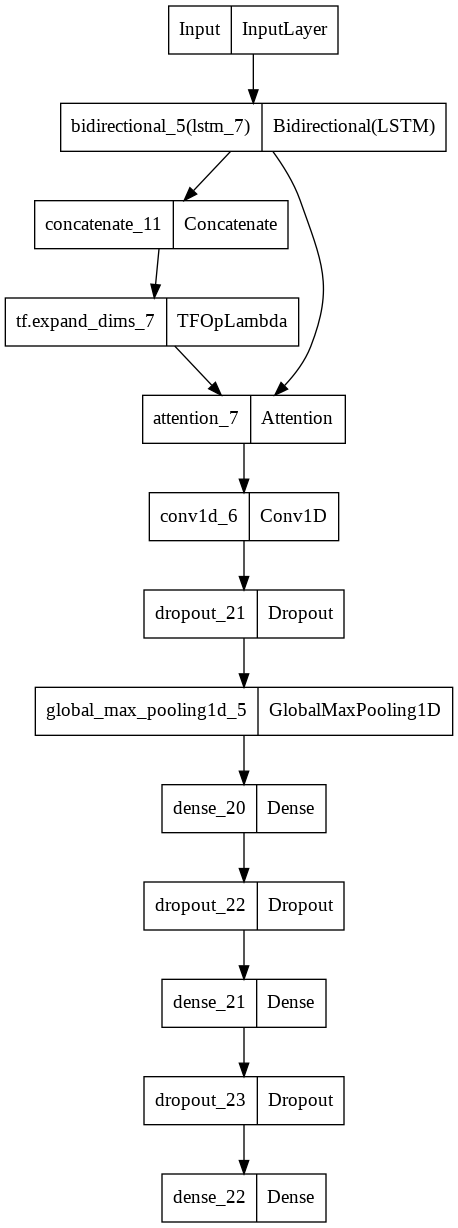

In [ ]:
model = build_BiLSTM_classifier(input_shape,classes)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

### STFT
https://doi.org/10.1038/s41598-021-99975-6 

based on this article's work we managed to obtain better performances thanks to the richer information provided to the model by applying ShortTimeFourierTransform to the input windows

In [ ]:
from scipy import signal

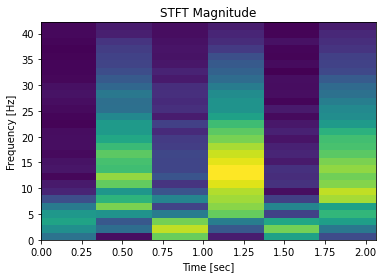

In [ ]:
f, t, Zxx = signal.stft(valUP[0][100], freq , nperseg=int(samples/3)) #use just samples (3 subwindow) for step 2 and use /3 for step 1 (6 samples)
Zxx=Zxx[0:30]
f=f[0:30]
plt.pcolormesh(t, f, np.abs(Zxx))
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

#crop at 40Hz since we filtered at that frequency so content above it

In [ ]:
Zxx.shape

(30, 7)

In [ ]:
band=Zxx.shape[0] #conservative
sub_window= int(samples/3)
time=Zxx.shape[1]

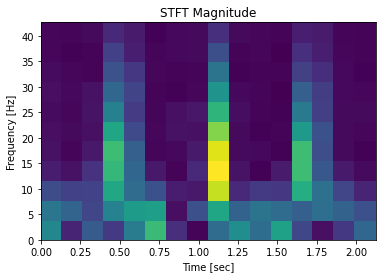

In [ ]:
f, t, Zxx = signal.stft(valUP[0][100], freq , nperseg=int(samples/8))
Zxx=Zxx[0:12]
f=f[0:12]
plt.pcolormesh(t, f, np.abs(Zxx))
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

#crop at 40Hz since we filtered at that frequency so content above it
#just to see the STFTs which were experimented with

In [ ]:
Zxx.shape

(12, 17)

In [ ]:
band2=Zxx.shape[0] #conservative
sub_window2= int(samples/8)
time2=Zxx.shape[1]

In [ ]:
#training set (as mentioned above, trials with whole dataset proved uncapable of learning the task)
if method != "2step":
  ZxxTR = np.empty(shape=(len(trainUPunder[0]),band,time,2)) 
  for i in range(len(trainUPunder[0])):
      f1,t1,val1= signal.stft(trainUPunder[0][i], freq , nperseg=sub_window)
      f2,t2,val2= signal.stft(trainUPunder[1][i], freq , nperseg=sub_window)
      ZxxTR[i,:,:,0]=np.abs(val1[0:band])
      ZxxTR[i,:,:,1]=np.abs(val2[0:band])

In [ ]:
band, time, sub_window

(30, 7, 88)

In [ ]:
#val set
ZxxV = np.empty(shape=(len(valUP[0]),band,time,2))
for i in range(len(valUP[0])):
    f1,t1,val1= signal.stft(valUP[0][i], freq , nperseg=sub_window)
    f2,t2,val2= signal.stft(valUP[1][i], freq , nperseg=sub_window)
    ZxxV[i,:,:,0]=np.abs(val1[0:band])
    ZxxV[i,:,:,1]=np.abs(val2[0:band])

In [ ]:
#val set under 
if method == "under":
  ZxxVunder = np.empty(shape=(len(valUPunder[0]),band,time,2))
  for i in range(len(valUPunder[0])):
      f1,t1,val1= signal.stft(valUPunder[0][i], freq, nperseg=sub_window)
      f2,t2,val2= signal.stft(valUPunder[1][i], freq, nperseg=sub_window)
      ZxxVunder[i,:,:,0]=np.abs(val1[0:band])
      ZxxVunder[i,:,:,1]=np.abs(val2[0:band])

#### For 2 step classification

In [ ]:
if method == "2step":
  #training set healthy
  ZxxTR = np.empty(shape=(len(trainUP[0]),band,time,2))
  for i in range(len(trainUP[0])):
      f1,t1,val1= signal.stft(trainUP[0][i], freq , nperseg=sub_window)
      f2,t2,val2= signal.stft(trainUP[1][i], freq , nperseg=sub_window)
      ZxxTR[i,:,:,0]=np.abs(val1[0:band])
      ZxxTR[i,:,:,1]=np.abs(val2[0:band])

In [ ]:
if method == "2step":
  #training set SV
  ZxxTR_SV = np.empty(shape=(len(trainSV[0]),band,time,2))
  for i in range(len(trainSV[0])):
      f1,t1,val1= signal.stft(trainSV[0][i], freq , nperseg=sub_window)
      f2,t2,val2= signal.stft(trainSV[1][i], freq , nperseg=sub_window)
      ZxxTR_SV[i,:,:,0]=np.abs(val1[0:band])
      ZxxTR_SV[i,:,:,1]=np.abs(val2[0:band])

In [ ]:
if method == "2step":
  #val set SV
  ZxxVSV = np.empty(shape=(len(valSV[0]),band,time,2))
  for i in range(len(valSV[0])):
      f1,t1,val1= signal.stft(valSV[0][i], freq, nperseg=sub_window)
      f2,t2,val2= signal.stft(valSV[1][i], freq, nperseg=sub_window)
      ZxxVSV[i,:,:,0]=np.abs(val1[0:band])
      ZxxVSV[i,:,:,1]=np.abs(val2[0:band])

#### Scaling between -1 and 1


In [ ]:
#fit on train set
m1=0
m2=0
for i in range(ZxxTR.shape[0]):
    for j in range(time):
        if max(ZxxTR[i,:,j,0])>m1:
            m1=max(ZxxTR[i,:,j,0])
        if max(ZxxTR[i,:,j,1])>m2:
            m2=max(ZxxTR[i,:,j,1])
print(m1,m2)

6.943412950379595 6.815962391462233


In [ ]:
#apply scaling
#train set
for i in range(ZxxTR.shape[0]):
    for j in range(time):
        for k in range (band):
            ZxxTR[i,k,j,0]=(ZxxTR[i,k,j,0])/(m1/2.)-1.
            ZxxTR[i,k,j,1]=(ZxxTR[i,k,j,1])/(m2/2.)-1.
#val set
for i in range(ZxxV.shape[0]):
    for j in range(time):
        for k in range (band):
            ZxxV[i,k,j,0]=(ZxxV[i,k,j,0])/(m1/2.)-1.
            ZxxV[i,k,j,1]=(ZxxV[i,k,j,1])/(m2/2.)-1.


In [ ]:
if method == "under":
  #val under
  for i in range(ZxxVunder.shape[0]):
      for j in range(time):
          for k in range (band):
              ZxxVunder[i,k,j,0]=(ZxxVunder[i,k,j,0])/(m1/2.)-1.
              ZxxVunder[i,k,j,1]=(ZxxVunder[i,k,j,1])/(m2/2.)-1.

In [ ]:
if method == "2step":
  #train SV
  for i in range(ZxxTR_SV.shape[0]):
      for j in range(time):
          for k in range (band):
              ZxxTR_SV[i,k,j,0]=(ZxxTR_SV[i,k,j,0])/(m1/2.)-1.
              ZxxTR_SV[i,k,j,1]=(ZxxTR_SV[i,k,j,1])/(m2/2.)-1.
  #val SV
  for i in range(ZxxVSV.shape[0]):
      for j in range(time):
          for k in range (band):
              ZxxVSV[i,k,j,0]=(ZxxVSV[i,k,j,0])/(m1/2.)-1.
              ZxxVSV[i,k,j,1]=(ZxxVSV[i,k,j,1])/(m2/2.)-1.

In [ ]:
STFT_shape=(band,time,2) #freq, time, leads

In [ ]:
STFT_shape2=(band2,time2,2) #freq, time, leads

In [ ]:
if method == "2step":
  classes=2

In [ ]:

my_model_name = "STFTclassifier3_264"
def build_STFT_classifier(input_shape, classes): #network as in article with slight adaptations to own dataset and task
    # Build the neural network layer by layer

    input_layer = tfkl.Input(shape=input_shape)

    #block 0
    conv0 = tfkl.Conv2D(128, kernel_size=(3,3), kernel_regularizer="l2", bias_regularizer="l2", activation="relu", padding="same")(input_layer)
    norm0 = tfkl.BatchNormalization()(conv0)
    pool0 = tfkl.MaxPooling2D((2,1))(norm0)
    drop0 = tfkl.Dropout(0.5, seed=seed)(pool0)
     
    #block 1
    conv1 = tfkl.Conv2D(64, kernel_size=(3,3), kernel_regularizer="l2", bias_regularizer="l2", activation="relu", padding="same")(drop0)
    norm1 = tfkl.BatchNormalization()(conv1)
    pool1 = tfkl.MaxPooling2D((2,1))(norm1)
    drop1 = tfkl.Dropout(0.5, seed=seed)(pool1)

    #block 2
    conv2 = tfkl.Conv2D(32, kernel_size=(2,2), kernel_regularizer="l2", bias_regularizer="l2", activation="relu", padding="same")(drop1)
    norm2 = tfkl.BatchNormalization()(conv2)
    pool2 = tfkl.MaxPooling2D((2,1))(norm2)
    drop2 = tfkl.Dropout(0.3, seed=seed)(pool2)

    #block 3
    conv3 = tfkl.Conv2D(16, kernel_size=(2,2), strides= (2,2), kernel_regularizer="l2", bias_regularizer="l2", activation="relu", padding="same")(drop2)
    norm3 = tfkl.BatchNormalization()(conv3)
    drop3 = tfkl.Dropout(0.3, seed=seed)(norm3)

    #flatten
    flat = tfkl.Flatten()(drop3)
    drop4 = tfkl.Dropout(0.3, seed=seed)(flat)

    #class probabilities
    
    output_layer = tfkl.Dense(classes, activation='softmax')(drop4)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.categorical_crossentropy, optimizer=tfk.optimizers.Adam(), metrics=['accuracy',bal_acc],run_eagerly=True)

    # Return the model
    return model

In [ ]:
if method == "2step":
  #for step 1

  #since for the 2 step training the dataset is not balanced, the metric used for the callbacks is the weighted accuracy (with weights given by different label proportions)
  #step 2 training proceded stabiliy with l2 factor at 0.01 as default but step 1 training is very unstable (unreliable model), for this reason regularization factor was increased and also the batch size
  #regardless the training is still unstable but final model's reliability is increased by the use of ensemble models
  def build_STFT_classifier(input_shape, classes):
  

      input_layer = tfkl.Input(shape=input_shape)

      #block 0
      conv0 = tfkl.Conv2D(128, kernel_size=(3,3), kernel_regularizer=tfk.regularizers.L2(l2=0.3), bias_regularizer=tfk.regularizers.L2(l2=0.3), activation="relu", padding="same", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed))(input_layer)
      norm0 = tfkl.BatchNormalization()(conv0)
      pool0 = tfkl.MaxPooling2D((2,1))(norm0)
      drop0 = tfkl.Dropout(0.5, seed=seed)(pool0)
      
      #block 1
      conv1 = tfkl.Conv2D(64, kernel_size=(3,3), kernel_regularizer=tfk.regularizers.L2(l2=0.3), bias_regularizer=tfk.regularizers.L2(l2=0.3), activation="relu", padding="same",kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed))(drop0)
      norm1 = tfkl.BatchNormalization()(conv1)
      pool1 = tfkl.MaxPooling2D((2,1))(norm1)
      drop1 = tfkl.Dropout(0.5, seed=seed)(pool1)

      #block 2
      conv2 = tfkl.Conv2D(32, kernel_size=(2,2), kernel_regularizer=tfk.regularizers.L2(l2=0.3), bias_regularizer=tfk.regularizers.L2(l2=0.3), activation="relu", padding="same",kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed))(drop1)
      norm2 = tfkl.BatchNormalization()(conv2)
      pool2 = tfkl.MaxPooling2D((2,1))(norm2)
      drop2 = tfkl.Dropout(0.3, seed=seed)(pool2)

      #block 3
      conv3 = tfkl.Conv2D(16, kernel_size=(2,2), strides= (2,2), kernel_regularizer=tfk.regularizers.L2(l2=0.3), bias_regularizer=tfk.regularizers.L2(l2=0.3), activation="relu", padding="same",kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed))(drop2)
      norm3 = tfkl.BatchNormalization()(conv3)
      drop3 = tfkl.Dropout(0.3, seed=seed)(norm3)

      #flatten
      flat = tfkl.Flatten()(drop3)
      drop4 = tfkl.Dropout(0.3, seed=seed)(flat)

      #class probabilities
      
      output_layer = tfkl.Dense(classes, activation='softmax')(drop4)

      # Connect input and output through the Model class
      model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

      # Compile the model
      model.compile(loss=tfk.losses.categorical_crossentropy, optimizer=tfk.optimizers.Adam(), metrics=['accuracy'], weighted_metrics=['accuracy'], run_eagerly=True)

      # Return the model
      return model

In [ ]:

if method == "2step":

  #for step 2
  def build_STFT_classifier2(input_shape, classes):
  

      input_layer = tfkl.Input(shape=input_shape)

      #block 0
      conv0 = tfkl.Conv2D(128, kernel_size=(3,3), activation="relu", kernel_regularizer="l2", bias_regularizer="l2",padding="same", kernel_initializer=tfk.initializers.HeNormal(seed=seed))(input_layer)
      norm0 = tfkl.BatchNormalization()(conv0)
      pool0 = tfkl.MaxPooling2D((2,1))(norm0)
      drop0 = tfkl.Dropout(0.2, seed=seed)(pool0)
      
      #block 1
      conv1 = tfkl.Conv2D(64, kernel_size=(3,3), activation="relu", padding="same", kernel_regularizer="l2", bias_regularizer="l2", kernel_initializer=tfk.initializers.HeNormal(seed=seed))(drop0)
      norm1 = tfkl.BatchNormalization()(conv1)
      pool1 = tfkl.MaxPooling2D((2,1))(norm1)
      drop1 = tfkl.Dropout(0.2, seed=seed)(pool1)

      #block 2
      conv2 = tfkl.Conv2D(32, kernel_size=(2,2), activation="relu", padding="same",kernel_regularizer="l2", bias_regularizer="l2", kernel_initializer=tfk.initializers.HeNormal(seed=seed))(drop1)
      norm2 = tfkl.BatchNormalization()(conv2)
      pool2 = tfkl.MaxPooling2D((2,1))(norm2)
      drop2 = tfkl.Dropout(0.2, seed=seed)(pool2)

      #block 3
      conv3 = tfkl.Conv2D(16, kernel_size=(2,2), strides= (2,2), activation="relu", padding="same",kernel_regularizer="l2", bias_regularizer="l2", kernel_initializer=tfk.initializers.HeNormal(seed=seed))(drop2)
      norm3 = tfkl.BatchNormalization()(conv3)
      drop3 = tfkl.Dropout(0.2, seed=seed)(norm3)

      #flatten
      flat = tfkl.Flatten()(drop3)
      drop4 = tfkl.Dropout(0.2, seed=seed)(flat)

      #class probabilities
      
      output_layer = tfkl.Dense(classes, activation='softmax')(drop4)

      # Connect input and output through the Model class
      model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

      # Compile the model
      model.compile(loss=tfk.losses.categorical_crossentropy, optimizer=tfk.optimizers.Adam(0.0005), metrics=['accuracy'], weighted_metrics=['accuracy'], run_eagerly=True)

      # Return the model
      return model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 30, 7, 2)]        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 30, 7, 128)        2432      
                                                                 
 batch_normalization_12 (Bat  (None, 30, 7, 128)       512       
 chNormalization)                                                
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 15, 7, 128)       0         
 2D)                                                             
                                                                 
 dropout_15 (Dropout)        (None, 15, 7, 128)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 15, 7, 64)         73792 

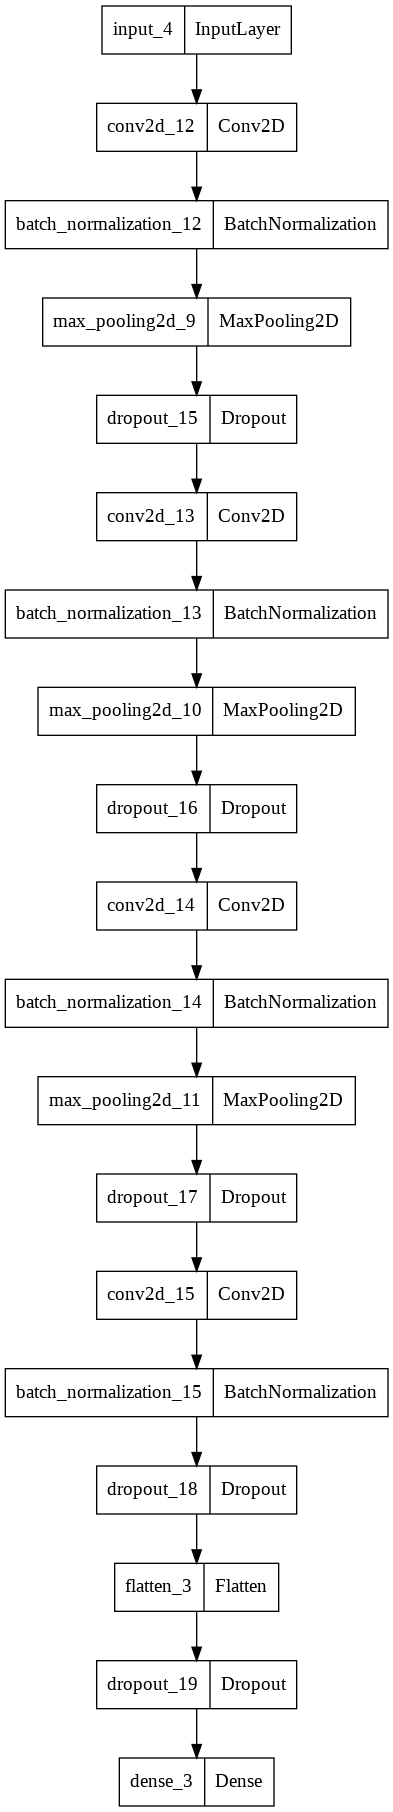

In [ ]:
model = build_STFT_classifier(STFT_shape,classes)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

In [ ]:

if method == "2step":
  model = build_STFT_classifier2(STFT_shape,classes)
  #model.summary()
  #tfk.utils.plot_model(model, expand_nested=True)


In [ ]:
(my_callbacks, exp_dir) = create_folders_and_callbacks(model_name=my_model_name)

if method == "bal":
  history = model.fit(
      x = ZxxTR,
      y = one_hot_labels,
      validation_data=(ZxxV , one_hot_labelsV , samples_weights), 
      epochs = 200,
      batch_size = 500,  
      class_weight=class_weights_alt, 
      callbacks = my_callbacks
      ).history
if method == "under":
  history = model.fit(
      x = ZxxTR,
      y = one_hot_labels,
      validation_data=(ZxxVunder , one_hot_labelsVunder , samples_weights), 
      epochs = 200,
      batch_size = 500, 
      class_weight=class_weights_alt,
      callbacks = my_callbacks
      ).history    
if method == "aug":
  history = model.fit(
      x = ZxxTR,
      y = one_hot_labels,
      validation_data=(ZxxVunder , one_hot_labelsVunder , samples_weights), 
      epochs = 200,
      batch_size = 500,  #increase to increase stability of validation loss/metrics during training
      callbacks = my_callbacks
      ).history

In [ ]:
if method == "2step":
  #step 1 
  my_model_name="STFT_step1_t7_ovf"
  (my_callbacks, exp_dir) = create_folders_and_callbacks_imb(model_name=my_model_name)
  history = model.fit(
      x = ZxxTR,
      y = one_hot_labelsH,
      validation_data=(ZxxV , one_hot_labelsVH, samples_weightsH), 
      epochs = 200,
      batch_size = 5000,             #increased to increase stability and also l2 factor was increased  (mind hindering of learning capability) (for step 1) 
      class_weight=class_weights_H,  
      callbacks = my_callbacks
      ).history

In [ ]:
if method == "2step":
  #step 2 
  my_model_name="STFT_step2_t7_stab"
  (my_callbacks, exp_dir) = create_folders_and_callbacks_imb(model_name=my_model_name)
  history = model.fit(
      x = ZxxTR_SV,
      y = one_hot_labelsSV,
      validation_data=(ZxxVSV , one_hot_labelsVSV, samples_weightsSV), 
      epochs = 200,
      batch_size = 500,  #notice that the dataset is much smaller for step 2 so batch size must be decreased proportionally
      class_weight=class_weights_SV,
      callbacks = my_callbacks
      ).history

### based on all model performances, for step 2 of 2 step classification
after considering all the models in this script taking in input the 2 lead ECG signal in time try to obtain one that can robustly distinguish between the 2 diseases; after trying different versions of them and adapting them to the smaller dataset, given by only S and V samples; hybrid models were attempted, trying to leverage upon the strengths highlighted for each single model: this one uses the parallel input branches by being passed the wider windowed hertbeat and also the more focused window (replicated here by cropping), as well as deep convolutional processing to efficiently extract relefant fatures and a dense -LSTM -dense classification top which was seen to pwrform better than the traditional dense feed forward classifier.

In [ ]:

my_model_name = "step2try_reg"
def build_step2_classifier(input_shape, classes=2): #multi input classifier was the one that better could distinguish among the 2 pethological classes

    input_layer = tfkl.Input(shape=input_shape)
    crop= tfkl.Cropping1D(cropping=(52, 82))(input_layer) #replicate the small window


    reg= tfk.regularizers.L2(l2=0.05)
    filters1= 16
    filters2= 32
    filters3=64
    filters4=128
    units1=32
    size_small=3
    size_medium=4
    size3=3
    act= tfkl.LeakyReLU(alpha=0.01)

    #small
    conv1small = tfkl.Conv1D(filters1, size_small, padding='same', activation=act,kernel_regularizer=reg)(crop)
    #conv1small = tfkl.Conv1D(filters1, size_small, padding='same', activation=act,kernel_regularizer=reg)(conv1small)
    pool1small = tfkl.MaxPool1D()(conv1small)
    drop1small = tfkl.Dropout(0.1,seed=seed)(pool1small) #0.2
    
    conv2small = tfkl.Conv1D(filters2, size_small, padding='same', activation=act,kernel_regularizer=reg)(drop1small)
    pool2small = tfkl.MaxPool1D()(conv2small)
    drop2small = tfkl.Dropout(0.1,seed=seed)(pool2small) #0.3

    #medium
    conv1medium = tfkl.Conv1D(filters1, size_medium, padding='same', activation=act,kernel_regularizer=reg)(input_layer)
    #conv1medium = tfkl.Conv1D(filters1, size_medium, padding='same', activation=act,kernel_regularizer=reg)(conv1medium)
    pool1medium = tfkl.MaxPool1D()(conv1medium)
    crop = tfkl.Cropping1D(cropping=1)(pool1medium)
    drop1medium = tfkl.Dropout(0.1,seed=seed)(crop)
    
    conv2medium = tfkl.Conv1D(filters2, size_medium, padding='same', activation=act,kernel_regularizer=reg)(drop1medium)
    pool2medium = tfkl.MaxPool1D(4)(conv2medium)
    drop2medium = tfkl.Dropout(0.1,seed=seed)(pool2medium)

    #concat
    conc = tfkl.Concatenate()([drop2small,drop2medium]) #concatenation requires dimensions to be camparable

    conv3 = tfkl.Conv1D(filters3, size3, padding='same', activation=act,kernel_regularizer=reg)(conc)
    pool3 = tfkl.MaxPool1D()(conv3)
    drop3 = tfkl.Dropout(0.2,seed=seed)(pool3)

    conv4 = tfkl.Conv1D(filters3, size3, padding='same', activation=act,kernel_regularizer=reg)(drop3)
    pool4 = tfkl.MaxPool1D()(conv4)
    drop4 = tfkl.Dropout(0.2,seed=seed)(pool4)

    #classifier
    flat = tfkl.GlobalMaxPooling1D()(drop4)
    classifier = tfkl.Dense(64, activation=act,kernel_regularizer=reg)(flat) 
    dropout1 = tfkl.Dropout(0.3, seed=seed)(classifier)


    classifier2 = tfkl.Dense(32, activation=act,kernel_regularizer=reg)(dropout1 )
    dropout2 = tfkl.Dropout(0.3, seed=seed)(classifier2)
    classifier3 = tfkl.Dense(16, activation=act,kernel_regularizer=reg)(dropout2)
    


    # LSTM branch (use also the LSTM output modality)
    lstm = tfkl.LSTM(100, return_sequences=False, kernel_regularizer=reg, recurrent_regularizer=reg)(tf.expand_dims(classifier3,axis=2))
    classlstm = tfkl.Dense(64, activation=act,kernel_regularizer=reg)(lstm)
    classlstm = tfkl.Dense(classes, activation=act,kernel_regularizer=reg)(classlstm)
    



    output_layer = tfkl.Dense(classes, activation='softmax')(classlstm)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.categorical_crossentropy, optimizer=tfk.optimizers.Adam(), metrics=['accuracy'], weighted_metrics=["accuracy"],run_eagerly=False)

    # Return the model
    return model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 264, 2)]     0           []                               
                                                                                                  
 cropping1d_6 (Cropping1D)      (None, 130, 2)       0           ['input_9[0][0]']                
                                                                                                  
 conv1d_20 (Conv1D)             (None, 264, 16)      144         ['input_9[0][0]']                
                                                                                                  
 conv1d_18 (Conv1D)             (None, 130, 16)      112         ['cropping1d_6[0][0]']           
                                                                                              

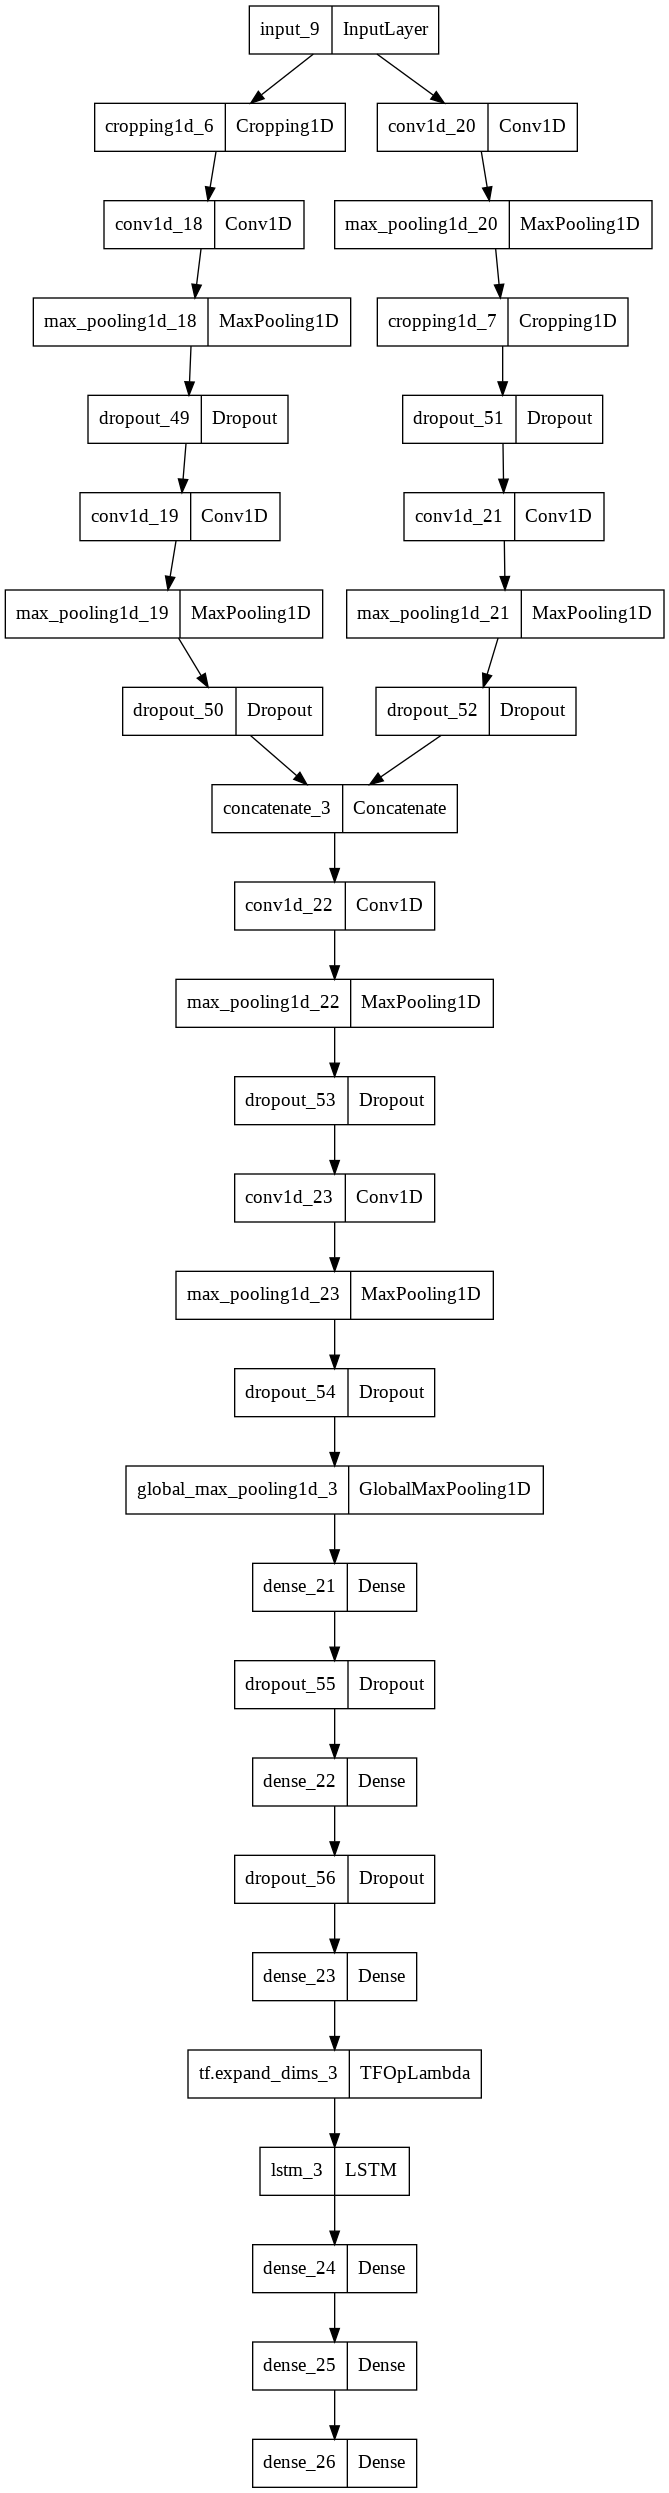

In [ ]:
model = build_step2_classifier((samples,2))
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

In [ ]:
(my_callbacks, exp_dir) = create_folders_and_callbacks_imb(model_name=my_model_name)
history = model.fit(
      x = np.concatenate([np.expand_dims(trainSV[0],axis=2),np.expand_dims(trainSV[1],axis=2)],axis=2),
      y = one_hot_labelsSV,
      validation_data=(np.concatenate([np.expand_dims(valSV[0],axis=2),np.expand_dims(valSV[1],axis=2)],axis=2),one_hot_labelsVSV, samples_weightsSV),
      epochs = 100,
      batch_size = 700,
      class_weight=class_weights_SV,
      callbacks = my_callbacks
      ).history


### Multi-output classifier
https://doi.org/10.1007/s42600-021-00176-x

model architecture taken from article, uses CNN to extract features and then both a dense and a LSTM as classifiers taking in input the extracted features; we then decidet to build a simple ensample on them

In [ ]:
def create_folders_and_callbacks_multiOUT(model_name):

  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = [
                tfk.callbacks.EarlyStopping(monitor='val_LSTMout_bal_acc', mode='max', patience=10, restore_best_weights=True),
                tfk.callbacks.ReduceLROnPlateau(monitor='val_LSTMout_bal_acc', mode='max', patience=10, factor=0.5, min_lr=1e-5)
              ]

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=True,  # True to save only the best epoch
                                                     monitor='val_LSTMout_bal_acc',
                                                     mode='max') 
  callbacks.append(ckpt_callback)


  return (callbacks, exp_dir)

In [ ]:
def performancePlot_multiOUT(tr_data, start_epoch, model_name, show=True, save = False, folder = "/" ):
    #Plot the training and validation data
    tbacc=tr_data['LSTMout_bal_acc']
    tloss=tr_data['LSTMout_loss']
    vbacc=tr_data['val_LSTMout_bal_acc']
    vloss=tr_data['val_LSTMout_loss']
    lr=tr_data['lr']
    tbaccf=tr_data['FCout_bal_acc']
    tlossf=tr_data['FCout_loss']
    vbaccf=tr_data['val_FCout_bal_acc']
    vlossf=tr_data['val_FCout_loss']


    Epoch_count=len(tbacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_bacc=np.argmax(vbacc)
    bacc_highest=vbacc[index_bacc]
    index_lossf=np.argmin(vlossf)
    val_lowestf=vlossf[index_lossf]
    index_baccf=np.argmax(vbaccf)
    bacc_highestf=vbaccf[index_baccf]


    plt.style.use('seaborn-darkgrid')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch) + "\nBest LossLSTM= " + str(round(val_lowest,4))
    vc_label='best epoch= '+ str(index_bacc + 1+ start_epoch) + "\nBest Bal. Acc LSTM= " + str(round(bacc_highest,4))
    sc_labelf='best epoch= '+ str(index_lossf+1 +start_epoch) + "\nBest LossFC= " + str(round(val_lowestf,4))
    vc_labelf='best epoch= '+ str(index_baccf + 1+ start_epoch) + "\nBest Bal. Acc FC= " + str(round(bacc_highestf,4))

    fig,axes=plt.subplots(nrows=1, ncols=5, figsize=(20,7), gridspec_kw={'width_ratios': [3, 3, 3,3,2]})
    # Set the graph titles
    st = fig.suptitle(model_name, fontsize="x-large", fontweight="bold")
    axes[0].plot(Epochs, tloss, linewidth=1.5,  label='Tr loss', marker='o', markersize=5)
    axes[0].plot(Epochs, vloss, linewidth=1.5,  label='Val loss', marker='o', markersize=5)
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=50, c= 'blue', marker='d', label=sc_label,  zorder = 10)
    axes[0].set_title('Tr and Val Loss LSTM')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    axes[1].plot(Epochs, tloss, linewidth=1.5,  label='Tr loss', marker='o', markersize=5)
    axes[1].plot(Epochs, vloss, linewidth=1.5,  label='Val loss', marker='o', markersize=5)
    axes[1].scatter(index_lossf+1 +start_epoch,val_lowestf, s=50, c= 'blue', marker='d', label=sc_labelf,  zorder = 10)
    axes[1].set_title('Tr and Val Loss FC')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    
    axes[2].plot (Epochs, tbacc, linewidth=1.5, label= 'Tr Bal.Acc', marker='o', markersize=5)
    axes[2].plot (Epochs, vbacc, linewidth=1.5, label= 'Val Bal.Acc', marker='o', markersize=5)
    axes[2].scatter(index_bacc+1 +start_epoch,bacc_highest, s=50, c= 'blue', marker='d', label=vc_label,  zorder = 10)
    axes[2].set_title('Tr and Val Bal Acc LSTM')
    axes[2].set_xlabel('Epochs')
    axes[2].set_ylabel('Bal Acc Cohen Score')
    axes[2].legend()

    axes[3].plot (Epochs, tbacc, linewidth=1.5, label= 'Tr Bal.Acc', marker='o', markersize=5)
    axes[3].plot (Epochs, vbacc, linewidth=1.5, label= 'Val Bal.Acc', marker='o', markersize=5)
    axes[3].scatter(index_baccf+1 +start_epoch,bacc_highestf, s=50, c= 'blue', marker='d', label=vc_labelf,  zorder = 10)
    axes[3].set_title('Tr and Val Bal Acc FC')
    axes[3].set_xlabel('Epochs')
    axes[3].set_ylabel('Bal Acc Cohen Score')
    axes[3].legend()

    axes[4].plot (Epochs, lr, linewidth=1.5, label= 'Learning Rate', marker='o', markersize=5)
    axes[4].set_title('Learning Rate')
    axes[4].set_xlabel('Epochs')
    axes[4].set_ylabel('Learning Rate')
    axes[4].legend()

    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    
    # Save should be before plot to avoid blank images
    if save:
      plt.savefig(str(folder + "/" + model_name + ".png"))
    if show:
      plt.show()

In [ ]:
my_model_name = "multiOUT264"
def build_multiOUT_classifier(input_shape, classes):  #adapted from article
    
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    
    reg='l2'

    conv1 = tfkl.Conv1D(32, 7, padding='same', activation='relu',kernel_regularizer=reg)(input_layer)
    pool1 = tfkl.MaxPooling1D(2)(conv1)

    conv2 = tfkl.Conv1D(64, 5, padding='same', activation='relu',kernel_regularizer=reg)(pool1)
    pool2 = tfkl.MaxPooling1D(2)(conv2)

    conv3 = tfkl.Conv1D(64, 6, padding='same', activation='relu',kernel_regularizer=reg)(pool2)
    pool3 = tfkl.MaxPooling1D(2)(conv2)

    conv4 = tfkl.Conv1D(64, 6, padding='same', activation='relu',kernel_regularizer=reg)(pool3)
    pool4 = tfkl.MaxPooling1D(2)(conv4)

    
    flat = tfkl.GlobalMaxPool1D()(pool4)
    #dropout= tfkl.Dropout(.5, seed=seed)(pool4)

    # common Classifier
    classifier = tfkl.Dense(30, activation='relu',kernel_regularizer='l2')(flat) 
    #dropout1 = tfkl.Dropout(.5, seed=seed)(classifier)
    classifier1=tfkl.Dense(30, activation='relu',kernel_regularizer='l2')(classifier)
    #dropout2 = tfkl.Dropout(.5, seed=seed)(classifier1)

    # FC branch
    classifier2 = tfkl.Dense(classes, activation='relu',kernel_regularizer='l2')(classifier1)
    outputFC = tfkl.Dense(classes, activation='softmax', name='FCout')(classifier2)

    # LSTM branch
    lstm = tfkl.LSTM(100, return_sequences=False, kernel_regularizer=reg, recurrent_regularizer=reg)(tf.expand_dims(classifier1,axis=2))
    classlstm = tfkl.Dense(64, activation='relu',kernel_regularizer='l2')(lstm)
    classlstm1 = tfkl.Dense(classes, activation='relu',kernel_regularizer='l2')(classlstm)
    outputlstm = tfkl.Dense(classes, activation='softmax', name='LSTMout')(classlstm1)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=[outputFC, outputlstm], name='model')

    # Compile the model
    model.compile(loss=tfk.losses.categorical_crossentropy, optimizer=tfk.optimizers.Adam(), metrics=['accuracy',bal_acc, f1],run_eagerly=True)

    # Return the model
    return model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 264, 2)]     0           []                               
                                                                                                  
 conv1d_8 (Conv1D)              (None, 264, 32)      480         ['Input[0][0]']                  
                                                                                                  
 max_pooling1d_8 (MaxPooling1D)  (None, 132, 32)     0           ['conv1d_8[0][0]']               
                                                                                                  
 conv1d_9 (Conv1D)              (None, 132, 64)      10304       ['max_pooling1d_8[0][0]']        
                                                                                              

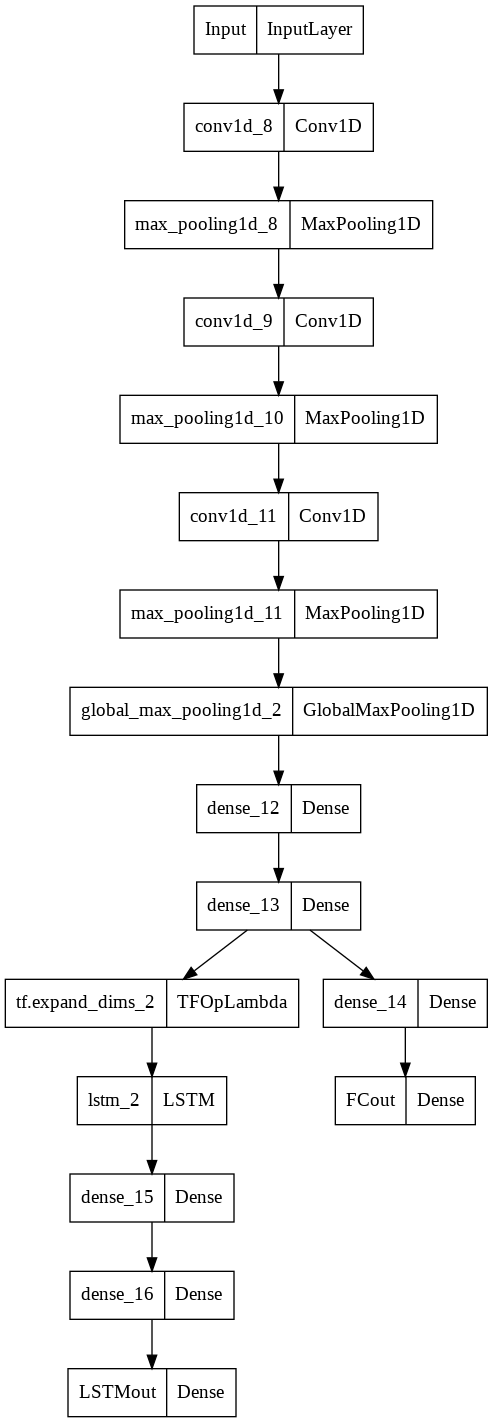

In [ ]:
model = build_multiOUT_classifier(input_shape,classes)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

In [ ]:
if method == "aug":
  (my_callbacks, exp_dir) = create_folders_and_callbacks_multiOUT(model_name=my_model_name)
  history = model.fit(
      x = np.concatenate([np.expand_dims(trainUPunder[0],axis=2),np.expand_dims(trainUPunder[1],axis=2)],axis=2),
      y = [one_hot_labels, one_hot_labels],
      validation_data=(np.concatenate([np.expand_dims(valUP[0],axis=2),np.expand_dims(valUP[1],axis=2)],axis=2),[one_hot_labelsV,one_hot_labelsV], samples_weights),
      epochs = 100,
      batch_size = 700,
      #class_weight=class_weights_alt,
      callbacks = my_callbacks
      ).history

### Multi-input classifier
use small and medium sized window to enphasise both rhythmic (wider information) and morphological (related to heartbeat to classify) as explained above

In [ ]:
my_model_name = "multiIN264_stab"
input_shape1= (samples_small,2)
input_shape2= (samples,2)
def build_multiIN_classifier(input_shape1, input_shape2, classes):  
    
    input_layer_small = tfkl.Input(shape=input_shape1, name='in1')
    input_layer_medium = tfkl.Input(shape=input_shape2, name='in2')

    reg='l2'
    filters1= 16
    filters2= 32
    filters3=64
    filters4=128
    units1=32
    size_small=3
    size_medium=4
    size3=3

    #small
    conv1small = tfkl.Conv1D(filters1, size_small, padding='same', activation='relu',kernel_regularizer=reg)(input_layer_small)
    pool1small = tfkl.MaxPool1D()(conv1small)
    drop1small = tfkl.Dropout(0.4,seed=seed)(pool1small) #0.2
    
    conv2small = tfkl.Conv1D(filters2, size_small, padding='same', activation='relu',kernel_regularizer=reg)(drop1small)
    pool2small = tfkl.MaxPool1D()(conv2small)
    drop2small = tfkl.Dropout(0.4,seed=seed)(pool2small) #0.3

    #medium
    conv1medium = tfkl.Conv1D(filters1, size_medium, padding='same', activation='relu',kernel_regularizer=reg)(input_layer_medium)
    pool1medium = tfkl.MaxPool1D()(conv1medium)
    crop = tfkl.Cropping1D(cropping=1)(pool1medium)
    drop1medium = tfkl.Dropout(0.4,seed=seed)(crop)
    
    conv2medium = tfkl.Conv1D(filters2, size_medium, padding='same', activation='relu',kernel_regularizer=reg)(drop1medium)
    pool2medium = tfkl.MaxPool1D(4)(conv2medium)
    drop2medium = tfkl.Dropout(0.4,seed=seed)(pool2medium)

    #concat
    conc = tfkl.Concatenate()([drop2small,drop2medium]) #concatenation requires dimensions to be camparable

    conv3 = tfkl.Conv1D(filters3, size3, padding='same', activation='relu',kernel_regularizer=reg)(conc)
    pool3 = tfkl.MaxPool1D()(conv3)
    drop3 = tfkl.Dropout(0.5,seed=seed)(pool3)

    conv4 = tfkl.Conv1D(filters3, size3, padding='same', activation='relu',kernel_regularizer=reg)(drop3)
    pool4 = tfkl.MaxPool1D()(conv4)
    drop4 = tfkl.Dropout(0.5,seed=seed)(pool4)

    #classifier
    flat = tfkl.GlobalMaxPooling1D()(drop4)
    classifier = tfkl.Dense(64, activation='relu',kernel_regularizer='l2')(flat) 
    dropout1 = tfkl.Dropout(0.5, seed=seed)(classifier)
    output_layer = tfkl.Dense(classes, activation='softmax')(dropout1)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=([input_layer_small, input_layer_medium]), outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.categorical_crossentropy, optimizer=tfk.optimizers.Adam(), metrics=['accuracy',bal_acc, f1], weighted_metrics=['accuracy'], run_eagerly=True)

    # Return the model
    return model

In [ ]:
model = build_multiIN_classifier(input_shape1, input_shape2,classes)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

In [ ]:
if method == "aug":
  (my_callbacks, exp_dir) = create_folders_and_callbacks_imb(model_name=my_model_name)
  history = model.fit(
      x = [np.concatenate([np.expand_dims(trainUPunder_small[0],axis=2),np.expand_dims(trainUPunder_small[1],axis=2)],axis=2) , np.concatenate([np.expand_dims(trainUPunder[0],axis=2),np.expand_dims(trainUPunder[1],axis=2)],axis=2)],
      y = one_hot_labels,
      validation_data=([np.concatenate([np.expand_dims(valUPsmall[0],axis=2),np.expand_dims(valUPsmall[1],axis=2)],axis=2) , np.concatenate([np.expand_dims(valUP[0],axis=2),np.expand_dims(valUP[1],axis=2)],axis=2)],one_hot_labelsV, samples_weights),
      epochs = 100,
      batch_size = 1000,
      #class_weight=class_weights_alt,
      callbacks = my_callbacks
      ).history

## Training

In [ ]:
#@title # Hyperparameters
epochs =  100#@param {type:"number"}
batch_size =  600#@param {type:"number"}

### Training with Pickle

In [ ]:
if method == "bal": #improves upon too imbalanced dataset
  (my_callbacks, exp_dir) = create_folders_and_callbacks(model_name=my_model_name)
  history = model.fit(
      x = np.concatenate([np.expand_dims(trainUPunder[0],axis=2),np.expand_dims(trainUPunder[1],axis=2)],axis=2),
      y = one_hot_labels,
      validation_data=(np.concatenate([np.expand_dims(valUP[0],axis=2),np.expand_dims(valUP[1],axis=2)],axis=2),one_hot_labelsV, samples_weights),
      epochs = epochs,
      batch_size = batch_size,
      class_weight=class_weights_alt,
      callbacks = my_callbacks
      ).history
if method == "under": #makes validation set comparable to training set during learning, (avoid TOO early stopping)
  (my_callbacks, exp_dir) = create_folders_and_callbacks(model_name=my_model_name)
  history = model.fit(
      x = np.concatenate([np.expand_dims(trainUPunder[0],axis=2),np.expand_dims(trainUPunder[1],axis=2)],axis=2),
      y = one_hot_labels,
      validation_data=(np.concatenate([np.expand_dims(valUPunder[0],axis=2),np.expand_dims(valUPunder[1],axis=2)],axis=2),one_hot_labelsVunder, samples_weights),
      epochs = epochs,
      batch_size = batch_size,
      class_weight=class_weights_alt,
      callbacks = my_callbacks
      ).history
if method == "aug": #increases performance by using the most data as possible while keeping the above advantages due to a balanced dataset (perfectly achieved here so no class_weight needed for training set)
  (my_callbacks, exp_dir) = create_folders_and_callbacks(model_name=my_model_name)
  history = model.fit(
      x = np.concatenate([np.expand_dims(trainUPunder[0],axis=2),np.expand_dims(trainUPunder[1],axis=2)],axis=2),
      y = one_hot_labels,
      validation_data=(np.concatenate([np.expand_dims(valUPunder[0],axis=2),np.expand_dims(valUPunder[1],axis=2)],axis=2),one_hot_labelsVunder, samples_weights),
      epochs = epochs,
      batch_size = batch_size,
      callbacks = my_callbacks
      ).history

Epoch 1/100
60/60 [==============================] - ETA: 0s - loss: 2.6969 - accuracy: 0.3704 - bal_acc: 0.0131

60/60 [==============================] - 47s 795ms/step - loss: 2.6969 - accuracy: 0.3704 - bal_acc: 0.0131 - val_loss: 1.9733 - val_accuracy: 0.1054 - val_bal_acc: 0.0000e+00 - lr: 0.0010
Epoch 2/100
60/60 [==============================] - ETA: 0s - loss: 1.6391 - accuracy: 0.3979 - bal_acc: 0.0081

60/60 [==============================] - 35s 591ms/step - loss: 1.6391 - accuracy: 0.3979 - bal_acc: 0.0081 - val_loss: 1.4187 - val_accuracy: 0.2935 - val_bal_acc: 8.5627e-04 - lr: 0.0010
Epoch 3/100
60/60 [==============================] - 15s 251ms/step - loss: 1.2934 - accuracy: 0.4120 - bal_acc: 0.0149 - val_loss: 1.2343 - val_accuracy: 0.1898 - val_bal_acc: 0.0000e+00 - lr: 0.0010
Epoch 4/100
60/60 [==============================] - 17s 283ms/step - loss: 1.1712 - accuracy: 0.4192 - bal_acc: 0.0203 - val_loss: 1.1640 - val_accuracy: 0.1476 - val_bal_acc: 0.0029 - lr: 0.0010
Epoch 5/100
60/60 [==============================] - 17s 283ms/step - loss: 1.1234 - accuracy: 0.4238 - bal_acc: 0.0223 - val_loss: 1.1352 - val_accuracy: 0.1786 - val_bal_acc: 6.0752e-04 - lr: 0.0010
Epoch 6/100
60/60 [==============================] - ETA: 0s - loss: 1.1029 - accuracy: 0.4208 - bal_acc: 0.0269

60/60 [==============================] - 35s 593ms/step - loss: 1.1029 - accuracy: 0.4208 - bal_acc: 0.0269 - val_loss: 1.1213 - val_accuracy: 0.6541 - val_bal_acc: 8.5627e-04 - lr: 0.0010
Epoch 7/100
60/60 [==============================] - ETA: 0s - loss: 1.0929 - accuracy: 0.4223 - bal_acc: 0.0309

60/60 [==============================] - 33s 563ms/step - loss: 1.0929 - accuracy: 0.4223 - bal_acc: 0.0309 - val_loss: 1.1185 - val_accuracy: 0.6671 - val_bal_acc: 0.0000e+00 - lr: 0.0010
Epoch 8/100
60/60 [==============================] - 17s 285ms/step - loss: 1.0868 - accuracy: 0.4213 - bal_acc: 0.0360 - val_loss: 1.1177 - val_accuracy: 0.6522 - val_bal_acc: 0.0027 - lr: 0.0010
Epoch 9/100
60/60 [==============================] - 15s 249ms/step - loss: 1.0843 - accuracy: 0.4230 - bal_acc: 0.0367 - val_loss: 1.1137 - val_accuracy: 0.6313 - val_bal_acc: 0.0139 - lr: 0.0010
Epoch 10/100
60/60 [==============================] - 17s 284ms/step - loss: 1.0823 - accuracy: 0.4193 - bal_acc: 0.0407 - val_loss: 1.1129 - val_accuracy: 0.6300 - val_bal_acc: 0.0087 - lr: 0.0010
Epoch 11/100
60/60 [==============================] - 15s 250ms/step - loss: 1.0805 - accuracy: 0.4245 - bal_acc: 0.0421 - val_loss: 1.1128 - val_accuracy: 0.5949 - val_bal_acc: 0.0239 - lr: 0.0010
Epoch 12/100
60/60 [=

60/60 [==============================] - 33s 554ms/step - loss: 1.0765 - accuracy: 0.4264 - bal_acc: 0.0520 - val_loss: 1.1151 - val_accuracy: 0.7042 - val_bal_acc: 0.0138 - lr: 0.0010
Epoch 18/100
60/60 [==============================] - 17s 285ms/step - loss: 1.0757 - accuracy: 0.4321 - bal_acc: 0.0485 - val_loss: 1.1168 - val_accuracy: 0.6872 - val_bal_acc: 0.0414 - lr: 0.0010
Epoch 19/100
60/60 [==============================] - 15s 249ms/step - loss: 1.0728 - accuracy: 0.4321 - bal_acc: 0.0632 - val_loss: 1.1166 - val_accuracy: 0.6814 - val_bal_acc: 0.0161 - lr: 0.0010
Epoch 20/100
60/60 [==============================] - 17s 284ms/step - loss: 1.0679 - accuracy: 0.4500 - bal_acc: 0.0771 - val_loss: 1.1248 - val_accuracy: 0.5704 - val_bal_acc: 4.9258e-04 - lr: 0.0010
Epoch 21/100
60/60 [==============================] - 15s 250ms/step - loss: 1.0537 - accuracy: 0.4723 - bal_acc: 0.1195 - val_loss: 1.1096 - val_accuracy: 0.5153 - val_bal_acc: 0.0010 - lr: 0.0010
Epoch 22/100
60/60 

60/60 [==============================] - 33s 556ms/step - loss: 1.0455 - accuracy: 0.4874 - bal_acc: 0.1946 - val_loss: 1.1433 - val_accuracy: 0.7091 - val_bal_acc: 0.0030 - lr: 0.0010
Epoch 25/100
60/60 [==============================] - 15s 252ms/step - loss: 1.0349 - accuracy: 0.4990 - bal_acc: 0.2100 - val_loss: 1.1294 - val_accuracy: 0.4425 - val_bal_acc: 0.1089 - lr: 0.0010
Epoch 26/100
60/60 [==============================] - ETA: 0s - loss: 1.0585 - accuracy: 0.4825 - bal_acc: 0.1695

60/60 [==============================] - 33s 558ms/step - loss: 1.0585 - accuracy: 0.4825 - bal_acc: 0.1695 - val_loss: 1.1483 - val_accuracy: 0.7415 - val_bal_acc: 0.0017 - lr: 0.0010
Epoch 27/100
60/60 [==============================] - ETA: 0s - loss: 1.0904 - accuracy: 0.4483 - bal_acc: 0.0780

60/60 [==============================] - 35s 595ms/step - loss: 1.0904 - accuracy: 0.4483 - bal_acc: 0.0780 - val_loss: 1.1450 - val_accuracy: 0.7684 - val_bal_acc: 0.0029 - lr: 0.0010
Epoch 28/100
60/60 [==============================] - 17s 286ms/step - loss: 1.0663 - accuracy: 0.4747 - bal_acc: 0.1325 - val_loss: 1.0709 - val_accuracy: 0.7282 - val_bal_acc: 0.0551 - lr: 0.0010
Epoch 29/100
60/60 [==============================] - 17s 283ms/step - loss: 1.0432 - accuracy: 0.4978 - bal_acc: 0.1997 - val_loss: 1.0676 - val_accuracy: 0.6211 - val_bal_acc: 0.1763 - lr: 0.0010
Epoch 30/100
60/60 [==============================] - 17s 283ms/step - loss: 1.0215 - accuracy: 0.5246 - bal_acc: 0.2557 - val_loss: 1.1447 - val_accuracy: 0.5155 - val_bal_acc: 0.0637 - lr: 0.0010
Epoch 31/100
60/60 [==============================] - 15s 249ms/step - loss: 0.9960 - accuracy: 0.5478 - bal_acc: 0.3130 - val_loss: 1.0997 - val_accuracy: 0.6068 - val_bal_acc: 0.1100 - lr: 0.0010
Epoch 32/100
60/60 [===

# Results
issues as overfitting and instability, as well as a general increase in performance were truely pondered only for the most promising models as regards capability to learn the task: this was mainly evaluated by analysing the confusion matrix regarding prediction on the validation set. 
For this reason the 2 Recurrent architectures were abandoned

### LSTM classifier
method "aug" (best)

In [ ]:
model.save(os.path.join(exps_dir, str('best_model/'+ my_model_name)))

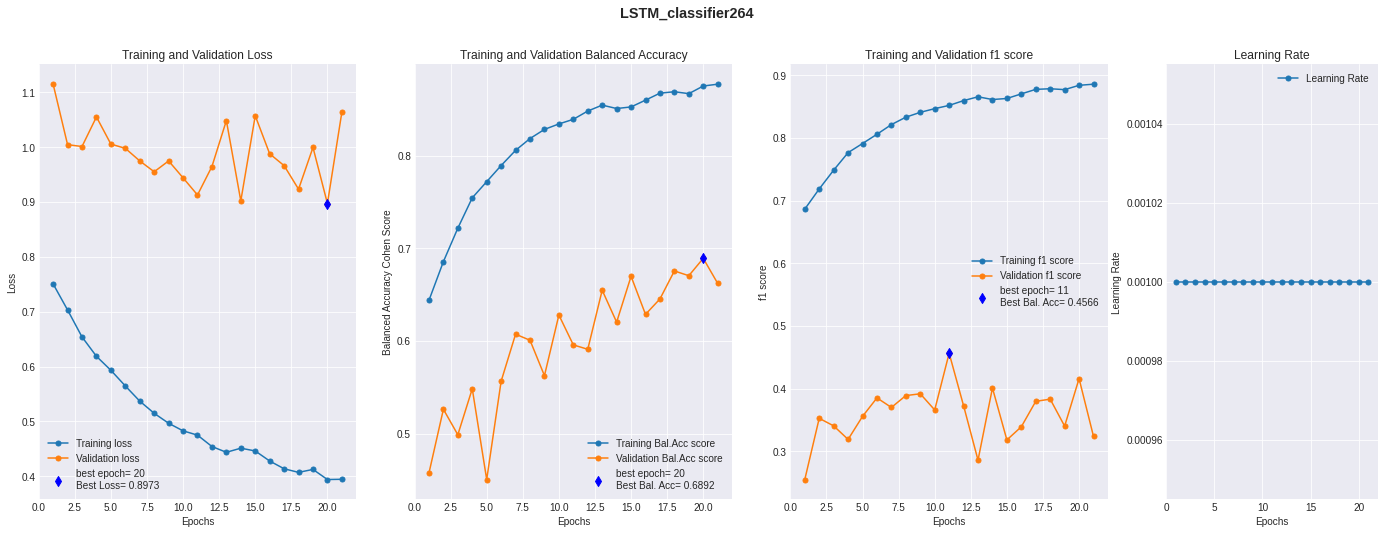

In [ ]:
performancePlot(history, 0, my_model_name, show=True, save = False)

In [ ]:
model = tfk.models.load_model(os.path.join(exps_dir, str('best_model/LSTM_classifier264')), custom_objects={"bal_acc":bal_acc, "f1":f1})

In [ ]:

prediction = model.predict(np.concatenate([np.expand_dims(valUP[0],axis=2),np.expand_dims(valUP[1],axis=2)],axis=2)) #use whole val set (better simulation of test data)


In [ ]:
matrix = confusion_matrix(K.argmax(K.round(one_hot_labelsV), axis=1), K.argmax(K.round(prediction),axis=1))

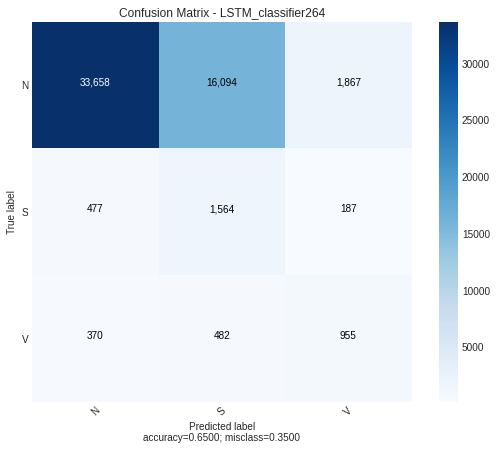

In [ ]:
plot_CMatrix(matrix = matrix,  target_names=['N', 'S', 'V'], normalize = False, title=str("Confusion Matrix - " + str(my_model_name)))

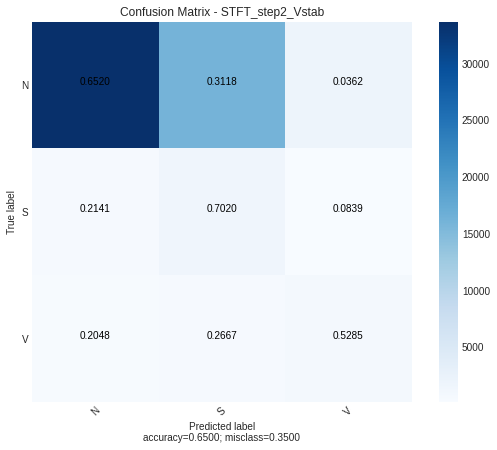

In [ ]:
plot_CMatrix(matrix = matrix,  target_names=['N', 'S', 'V'], normalize = True, title=str("Confusion Matrix - " + str(my_model_name)))

### BiLSTM classifier
method "aug" (best)

In [ ]:
# epochs : 27          batch_size : 600

In [ ]:
model.save(os.path.join(exps_dir, str('best_model/'+ my_model_name)))

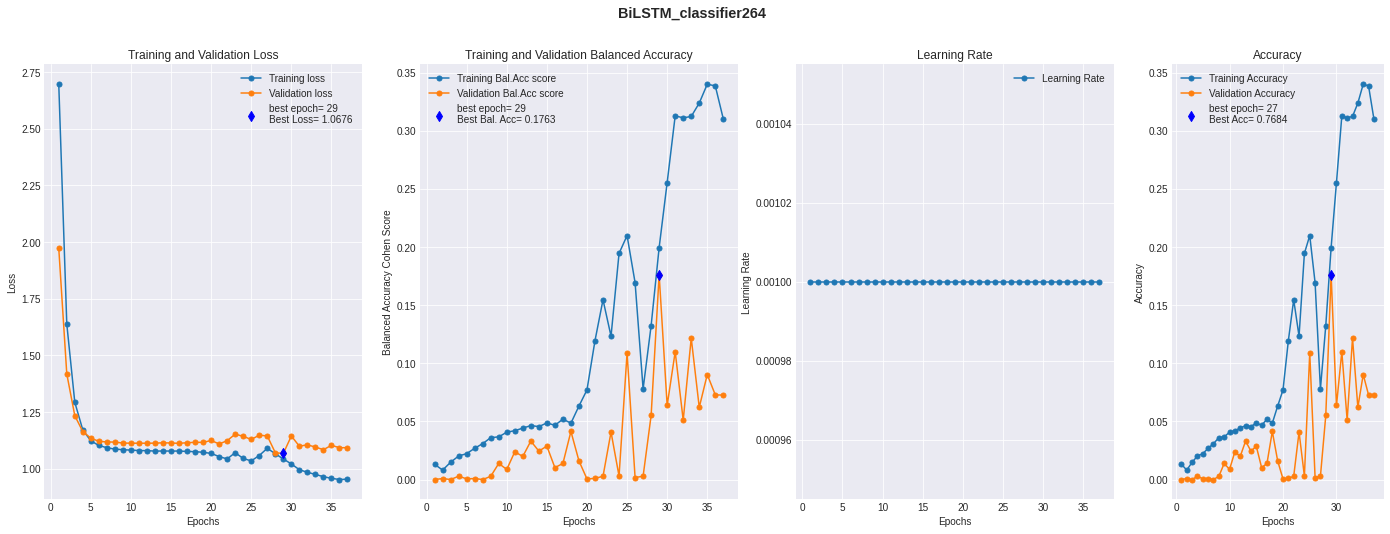

In [ ]:
performancePlot_no_f1(history, 0, my_model_name, show=True, save = False)

In [ ]:
model = tfk.models.load_model(os.path.join(exps_dir, str('best_model/BiLSTM_classifier264')), custom_objects={"bal_acc":bal_acc})

In [ ]:

prediction = model.predict(np.concatenate([np.expand_dims(valUP[0],axis=2),np.expand_dims(valUP[1],axis=2)],axis=2))


In [ ]:
matrix = confusion_matrix(K.argmax(K.round(one_hot_labelsV), axis=1), K.argmax(K.round(prediction),axis=1))

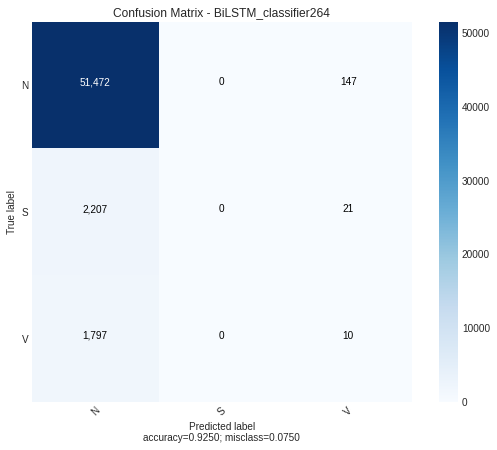

In [ ]:
plot_CMatrix(matrix = matrix,  target_names=['N', 'S', 'V'], normalize = False, title=str("Confusion Matrix - " + str(my_model_name)))

In [ ]:
f1_m= sklearn.metrics.f1_score(one_hot_labelsV,prediction.round(), average="samples")
ht_m= ht(one_hot_labelsV,prediction)
f1_m, ht_m

(0.00017968160419736228, 0.1409942980365535)

### STFT classifier
method "bal"

In [ ]:
model.save(os.path.join(exps_dir, str('best_model/'+ my_model_name)))

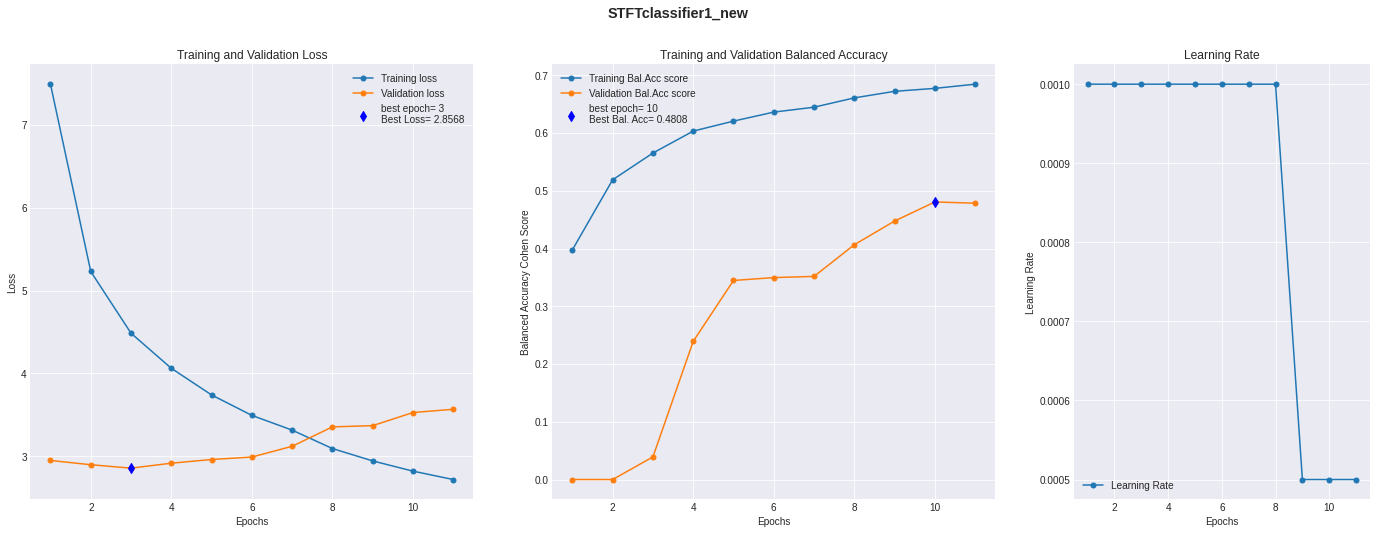

In [ ]:
performancePlot_no_f1(history, 0, my_model_name, show=True, save = False)

In [ ]:
model = tfk.models.load_model(os.path.join(exps_dir, str('best_model/STFTclassifier')))

In [ ]:

prediction = model.predict(ZxxV)


In [ ]:
matrix = confusion_matrix(K.argmax(K.round(one_hot_labelsV), axis=1), K.argmax(K.round(prediction),axis=1))

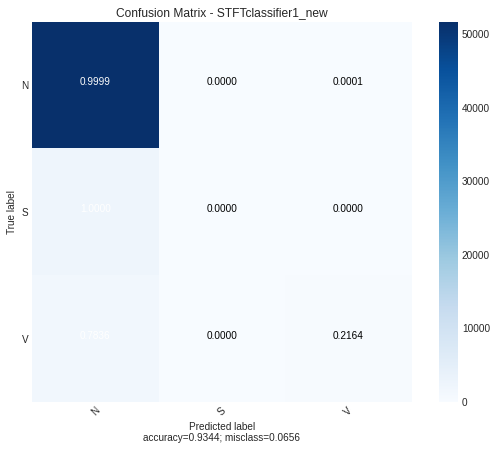

In [ ]:
plot_CMatrix(matrix = matrix,  target_names=['N', 'S', 'V'], normalize = True, title=str("Confusion Matrix - " + str(my_model_name)))

### STFT classifier
method "under" different values of N samples reduction were attempted but no satisfying tradeoff was obtained

In [ ]:
model.save(os.path.join(exps_dir, str('best_model/'+ my_model_name)))

In [ ]:
performancePlot_no_f1(history, 0, my_model_name, show=True, save = False)

In [ ]:
model = tfk.models.load_model(os.path.join(exps_dir, str('best_model/STFTclassifier')), custom_objects={'bal_acc': bal_acc})

In [ ]:

prediction = model.predict(ZxxV) #use whole val set (better simulation of test data)



In [ ]:
matrix = confusion_matrix(K.argmax(K.round(one_hot_labelsV), axis=1), K.argmax(K.round(prediction),axis=1))

In [ ]:
plot_CMatrix(matrix = matrix,  target_names=['N', 'S', 'V'], normalize = True, title=str("Confusion Matrix - " + str(my_model_name)))

### STFT classifier
method "aug"
overfitting and stability can easily be reduced by increasing regularization coefficient, dropout and batch size; values on the confusion matrix diagonal are increasing but still not optimal; this is selected as the best model so far so 2 step classification is attempted with it.

In [ ]:
model.save(os.path.join(exps_dir, str('best_model/'+ my_model_name)))

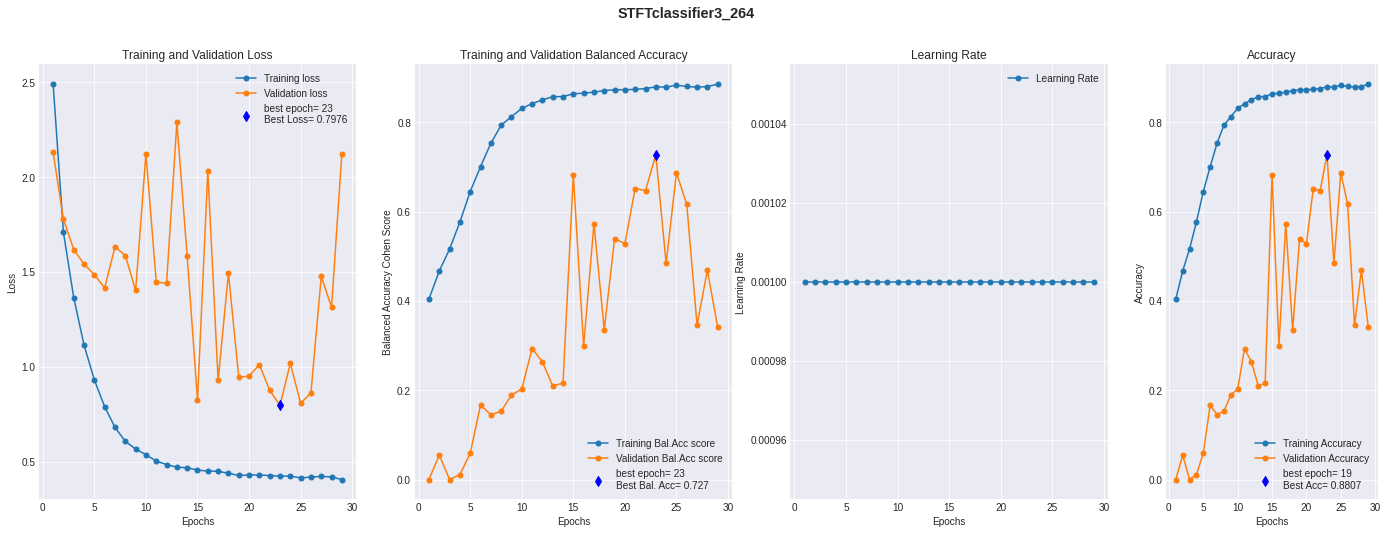

In [ ]:
performancePlot_no_f1(history, 0, my_model_name, show=True, save = False)

In [ ]:
model = tfk.models.load_model(os.path.join(exps_dir, str('best_model/STFTclassifier')), custom_objects={'bal_acc': bal_acc})

In [ ]:
#prediction = model.predict(np.concatenate([np.expand_dims(valUP[0],axis=2),np.expand_dims(valUP[1],axis=2)],axis=2))
prediction = model.predict(ZxxV) #use whole val set (better simulation of test data)

#decoded_validation = np.argmax(one_hot_labelsV, axis=1)
# Remove variable for RAM
#del one_hot_labelsV
#decoded_prediction = np.argmax(np.around(prediction), axis=1)
# Remove variable for RAM
#del prediction 

In [ ]:
matrix = confusion_matrix(K.argmax(K.round(one_hot_labelsV), axis=1), K.argmax(K.round(prediction),axis=1))

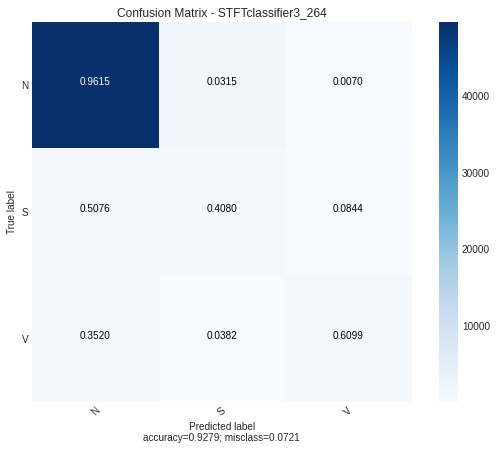

In [ ]:
plot_CMatrix(matrix = matrix,  target_names=['N', 'S', 'V'], normalize = True, title=str("Confusion Matrix - " + str(my_model_name)))

## Multi-input classifier
method "aug"
Good improvement on S/V distinction but S is too often predicted as N

In [ ]:
model.save(os.path.join(exps_dir, str('best_model/'+ my_model_name)))

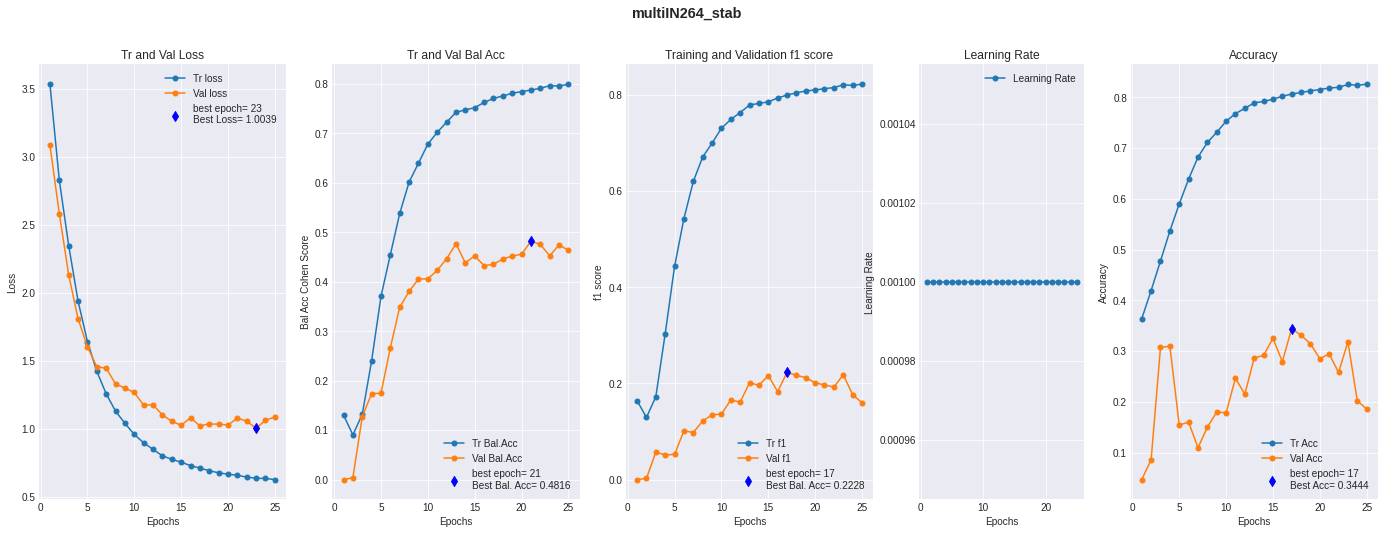

In [ ]:
performancePlot(history, 0, my_model_name, show=True, save = False)

In [ ]:
model = tfk.models.load_model(os.path.join(exps_dir, str('best_model/multiINPUT_classifier_stab')))

In [ ]:

prediction = model.predict([np.concatenate([np.expand_dims(valUPsmall[0],axis=2),np.expand_dims(valUPsmall[1],axis=2)],axis=2) , np.concatenate([np.expand_dims(valUP[0],axis=2),np.expand_dims(valUP[1],axis=2)],axis=2)]) #use whole val set (better simulation of test data)


In [ ]:
matrix = confusion_matrix(K.argmax(K.round(one_hot_labelsV), axis=1), K.argmax(K.round(prediction),axis=1))

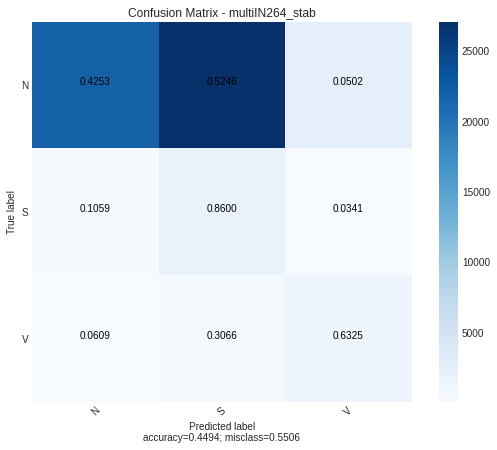

In [ ]:
plot_CMatrix(matrix = matrix,  target_names=['N', 'S', 'V'], normalize = True, title=str("Confusion Matrix - " + str(my_model_name)))

## Multi-output classifier
method "aug"

In [ ]:
model.save(os.path.join(exps_dir, str('best_model/'+ my_model_name)))

In [ ]:
performancePlot_multiOUT(history, 0, my_model_name, show=True, save = False)

In [ ]:
model = tfk.models.load_model(os.path.join(exps_dir, str('best_model/LSTMclassifier')))

In [ ]:

[predictionFC, predictionLSTM] = model.predict(np.concatenate([np.expand_dims(valUP[0],axis=2),np.expand_dims(valUP[1],axis=2)],axis=2)) #use whole val set (better simulation of test data)

#decoded_validation = np.argmax(one_hot_labelsV, axis=1)
# Remove variable for RAM
#del one_hot_labelsV
#decoded_prediction = np.argmax(np.around(prediction), axis=1)
# Remove variable for RAM
#del prediction 

In [ ]:
matrixFC = confusion_matrix(K.argmax(K.round(one_hot_labelsV), axis=1), K.argmax(K.round(predictionFC),axis=1))

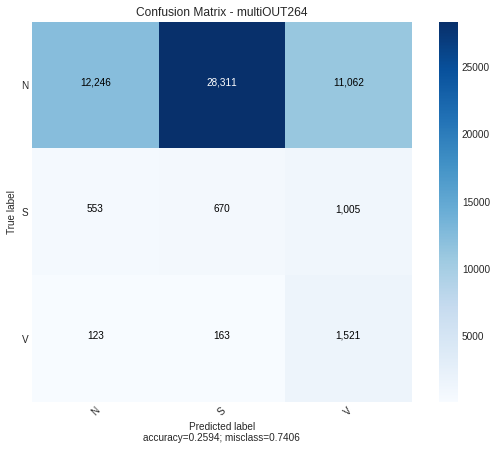

In [ ]:
plot_CMatrix(matrix = matrixFC,  target_names=['N', 'S', 'V'], normalize = False, title=str("Confusion Matrix - " + str(my_model_name))) #for FC output

In [ ]:
matrixLSTM = confusion_matrix(K.argmax(K.round(one_hot_labelsV), axis=1), K.argmax(K.round(predictionLSTM),axis=1))

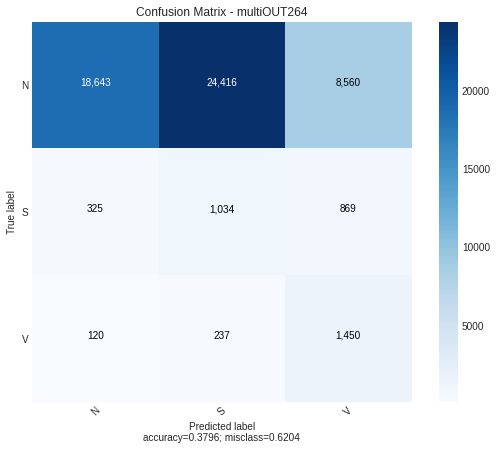

In [ ]:
plot_CMatrix(matrix = matrixLSTM,  target_names=['N', 'S', 'V'], normalize = False, title=str("Confusion Matrix - " + str(my_model_name))) #for LSTM output

#### Make simple ensemble with the 2 output heads'predictions

In [ ]:
predictionFC.shape, predictionLSTM.shape

((55654, 3), (55654, 3))

In [ ]:
FTmatrix_train  = np.concatenate([np.expand_dims(predictionFC, axis=2),np.expand_dims(predictionLSTM, axis=2)], axis=2) 
FTmatrix_train.shape

(55654, 3, 2)

In [ ]:
values_grid = np.arange(0.01, 0.99, 0.01);

def prediction (matrix, a, b):
  lista = np.empty((matrix.shape[0],matrix.shape[1]))
  for i in range (matrix.shape[0]):
    N = a*matrix[i][0][0] + b*matrix[i][0][1]
    S = a*matrix[i][1][0] + b*matrix[i][1][1]
    V = a*matrix[i][2][0] + b*matrix[i][2][1]
    lista[i][0]=N
    lista[i][1]=S
    lista[i][2]=V

  return lista

In [ ]:
def bal_acc_ens(y_true, y_pred):
  # 1) Numpy Conversion
  #true = y_true.numpy()
  #pred = y_pred.numpy()
  # 1b) From probability to int
  true = np.round(y_true)
  pred = np.round(y_pred)

  # 2) Extract the number of beats for each class
  true_N = true[:,0]
  true_S = true[:,1]
  true_V = true[:,2]
  n_N = np.count_nonzero(true_N, axis=0)
  n_S = np.count_nonzero(true_S, axis=0)
  n_V = np.count_nonzero(true_V, axis=0)

  # Compute the total number of beats in the batch
  #print("n_N:", n_N,"n_S:", n_S,"n_V:", n_V)
  #totSample = n_N + n_V + n_S

  # 3) Compute the majority class
  max_class = [n_N, n_S, n_V]
  max_class.sort()
  #print("max_class:", max_class[-1])

  # 4) Compute the weights for the balanced mean (max_class + beats per class)
  if n_N != 0 and n_S != 0 and n_V != 0:
    wN = max_class[-1]/n_N
    wS = max_class[-1]/n_S
    wV = max_class[-1]/n_V

    # 5) Compute True Positive Number
    # Slice the predictor in  the different classes
    pred_N = pred[:,0]
    pred_S = pred[:,1]
    pred_V = pred[:,2]

    # Compute True Positive
    tp_N = np.count_nonzero(true_N*pred_N, axis=0)
    tp_S = np.count_nonzero(true_S*pred_S, axis=0)
    tp_V = np.count_nonzero(true_V*pred_V, axis=0)

    # 6) balanced Accuracy
    #print(" - N:", tp_N/n_N, "S:", tp_V/n_V, "V:", tp_S/n_S)
    #print(" --> wN:", wN,"wS:", wS,"wV:", wV)
    return(((tp_N/n_N)*wN + (tp_S/n_S)*wS + (tp_V/n_V)*wV) / (wN + wS + wV))

  elif n_S != 0 and n_V == 0:
    wN = max_class[-1]/n_N
    wS = max_class[-1]/n_S

    # 5) Compute True Positive Number
    # Slice the predictor in  the different classes
    pred_N = pred[:,0]
    pred_S = pred[:,1]

    # Compute True Positive
    tp_N = np.count_nonzero(true_N*pred_N, axis=0)
    tp_S = np.count_nonzero(true_S*pred_S, axis=0)

    # 6) balanced Accuracy
    #print(" - N:", tp_N/n_N,"S:", tp_S/n_S)
    #print(" --> wN:", wN,"wS:", wS)
    return(((tp_N/n_N)*wN + (tp_S/n_S)*wS) / (wN + wS))

  elif n_S == 0 and n_V != 0:
    wN = max_class[-1]/n_N
    wV = max_class[-1]/n_V

    # 5) Compute True Positive Number
    # Slice the predictor in  the different classes
    pred_N = pred[:,0]
    pred_V = pred[:,2]

    # Compute True Positive
    tp_N = np.count_nonzero(true_N*pred_N, axis=0)
    tp_V = np.count_nonzero(true_V*pred_V, axis=0)

    # 6) balanced Accuracy
    #print(" - N:", tp_N/n_N,"V:", tp_V/n_V)
    #print(" --> wN:", wN,"wV:", wV)
    return(((tp_N/n_N)*wN + (tp_V/n_V)*wV) / (wN + wV))

  elif n_S == 0 and n_V == 0:
    # 5) Compute True Positive Number
    # Slice the predictor in  the different classes
    pred_N = pred[:,0]

    # Compute True Positive
    tp_N = np.count_nonzero(true_N*pred_N, axis=0)

    # 6) balanced Accuracy
    #print(" - N:", tp_N/n_N,)
    return(tp_N/n_N)

also logistic regression and decision tree, which wile being more powerful tools maintain interpretability; but this path was not explored since it did not seem promising because both branches seem to make the same missclassifications

In [ ]:
best = [0, 0]
y_pred=np.empty((FTmatrix_train.shape[0],FTmatrix_train.shape[1]))
acc_max = 0
for a in values_grid:
  for b in values_grid:
      if(a+b == 1):
        y_pred = prediction(FTmatrix_train, a, b)
        #y_pred = np.asarray(y_pred)
        acc = bal_acc_ens(one_hot_labelsV,y_pred)
        if acc > acc_max : 
          acc_max = acc
          best[0] = a
          best[1] = b

print(best)

[0.04, 0.9600000000000001]


In [ ]:
#performances should ideally be evaluated on a separated set than the one used to train the weights for the linear combinations of the predictions
ens_pred = prediction(FTmatrix_train, best[0], best[1])


In [ ]:
matrixENS = confusion_matrix(K.argmax(K.round(one_hot_labelsV), axis=1), K.argmax(K.round(ens_pred),axis=1))

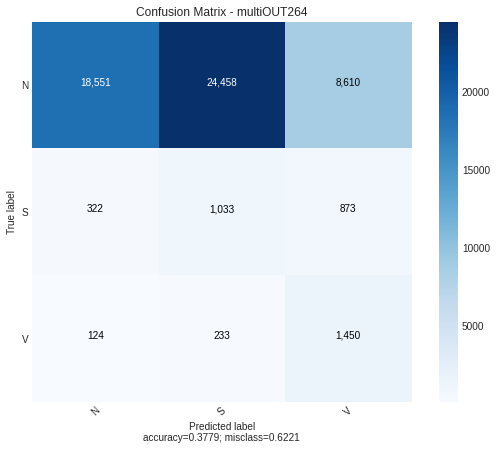

In [ ]:
plot_CMatrix(matrix = matrixENS,  target_names=['N', 'S', 'V'], normalize = False, title=str("Confusion Matrix - " + str(my_model_name)))

# STFT classifier
2 step classification: this model, which so far is better able to learn the task should gratly benefit from this task semplification by grouping and serialization

### Step 1 
stability is particularly critical although performances are good (the risk is of low model robustness but this is increased using ensembles).
For this reason bayesian optimizer (from keras tuners) was not used in this case since increasing acc or weighted acc is not as critical as obtaining a stable validation trend.
To improve stability batch size and l2 regularizer coefficient were increased considerably

In [ ]:
model.save(os.path.join(exps_dir, str('best_model/'+ "STFT_step1_stab_ovf"))) 

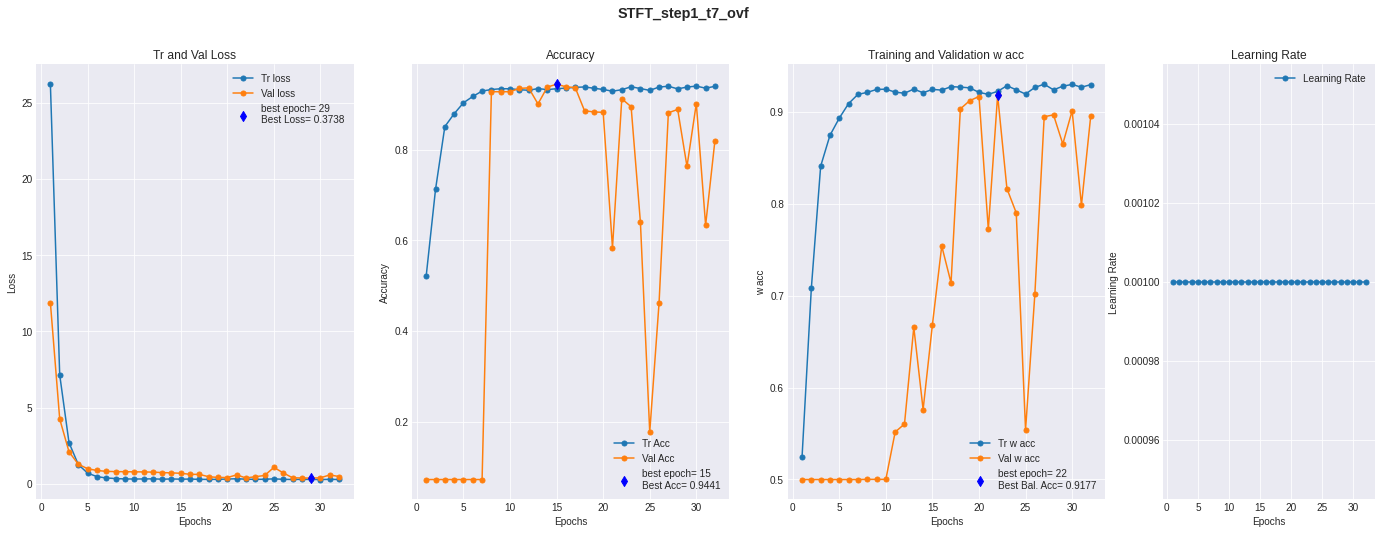

In [ ]:
performancePlot_2acc(history, 0, my_model_name, show=True, save = False) #satisfyingly stable at least until the best epoch (before which the weights for the best model are saved)

In [ ]:
prediction = model.predict(ZxxV)

In [ ]:
matrix = confusion_matrix(K.argmax(K.round(one_hot_labelsVH), axis=1), K.argmax(K.round(prediction),axis=1))

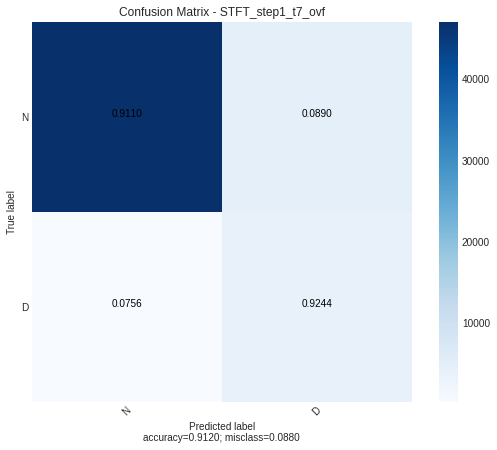

In [ ]:
plot_CMatrix(matrix = matrix,  target_names=['N', 'D'], normalize = True, title=str("Confusion Matrix - " + str(my_model_name)))
#notice how there is a slight bias towards D prediction but this is good since it medicine false positives are preferred over false negatives

In [ ]:
ht_H= ht(one_hot_labelsVH,prediction) #best for healthy/pathological distinction
ht_H

0.909896639437987

In [ ]:
f1_H = sklearn.metrics.f1_score(one_hot_labelsVH,prediction.round(), average="samples")
f1_H

0.865328637654077

#### Step 2
try stabilizing (reg and batch)

In [ ]:
model.save(os.path.join(exps_dir, str('best_model/'+ my_model_name)))

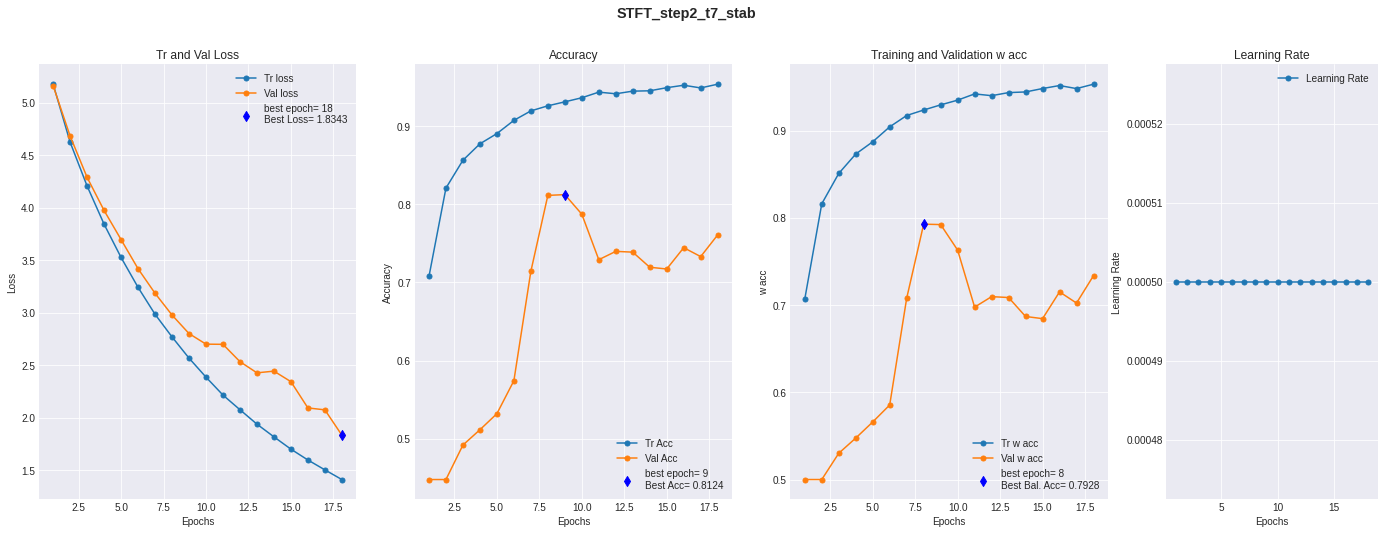

In [ ]:
performancePlot_2acc(history, 0, my_model_name, show=True, save = False) 
#overfitting is more problematic than stability for step 2 but any attempt to reduce it resulted in a drastic decrease of performances so at cost of risking low robustness as regards generalization this is considered to be the best performance 

In [ ]:

prediction = model.predict(ZxxVSV)


In [ ]:
matrix = confusion_matrix(K.argmax(K.round(one_hot_labelsVSV), axis=1), K.argmax(K.round(prediction),axis=1))

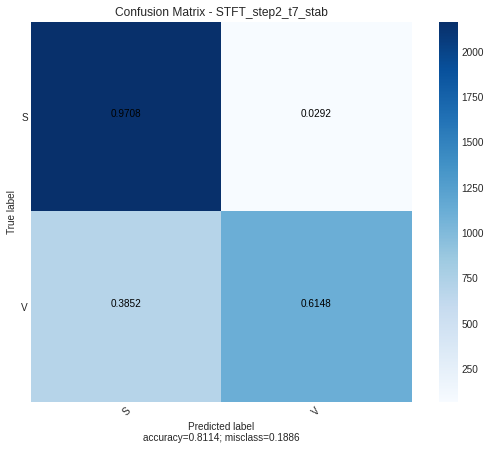

In [ ]:
plot_CMatrix(matrix = matrix,  target_names=['S', 'V'], normalize = True, title=str("Confusion Matrix - " + str(my_model_name)))
#the issue of mistaking V for S is still slightly present but in reduced form; what's most important though is having reduced the number missclassifications in step 1;
#furthermore improvements in step 2 can be achieved by combing this model's outputs with those from models taking in inpu wide features

In [ ]:
ht_SV= ht(one_hot_labelsVSV,prediction) #nest for PAC/PVC distinction
ht_SV #notice how the harmonic trace metric penalizes, more than f1, missclassifications; this is done to penalize models which are biased towards the prediction of the majority class

0.7528665021770143

In [ ]:
f1_SV= sklearn.metrics.f1_score(one_hot_labelsVSV,prediction.round(), average="samples")
f1_SV

0.8114002478314746

#### Step 2 with network born from all considerations so far regarding the models theorically more adequate to extracting morphological differences from the signals

In [ ]:
model.save(os.path.join(exps_dir, str('best_model/'+ my_model_name)))

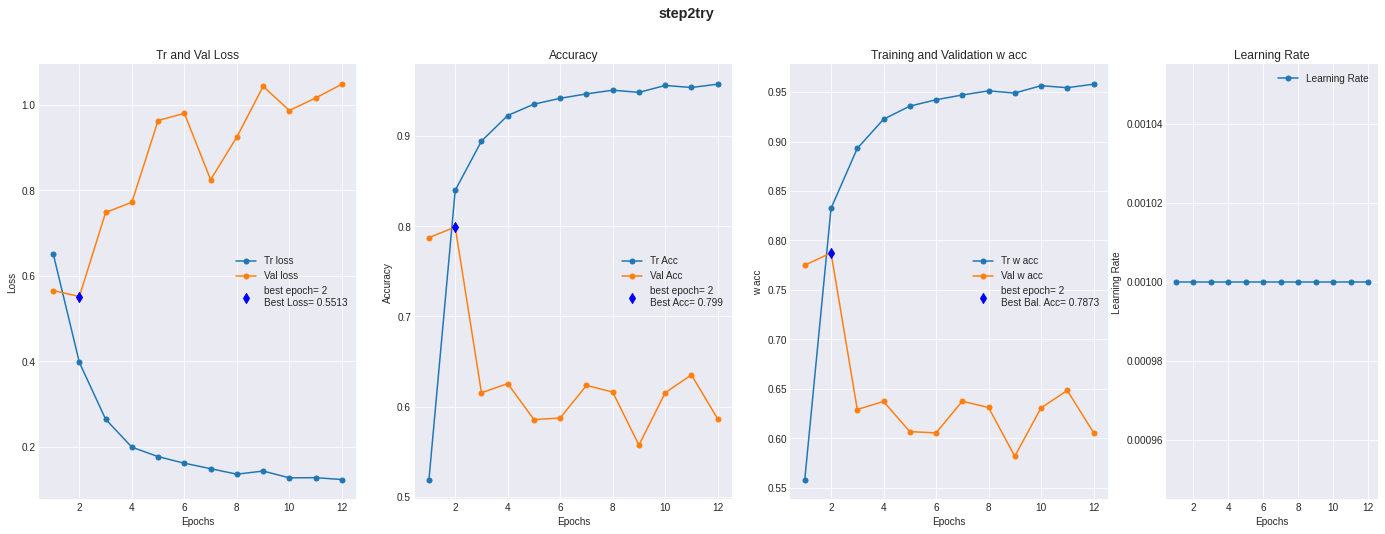

In [ ]:
performancePlot_2acc(history, 0, my_model_name, show=True, save = False)
#the model is probably too complex but all attempt to simplify it or the different simpler architectures (as the first LSTM input model) gave much worse performances

In [ ]:

prediction = model.predict(np.concatenate([np.expand_dims(valSV[0],axis=2),np.expand_dims(valSV[1],axis=2)],axis=2)) 


In [ ]:
matrix = confusion_matrix(K.argmax(K.round(one_hot_labelsVSV), axis=1), K.argmax(K.round(prediction),axis=1))

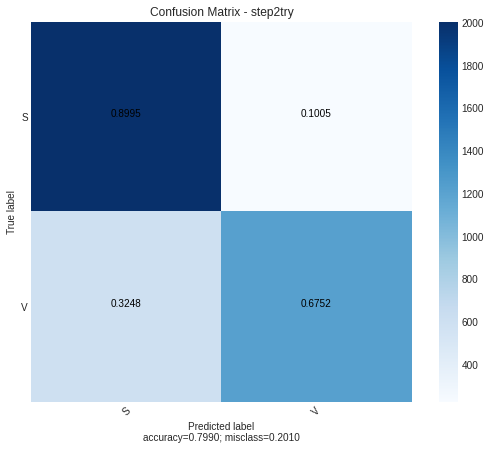

In [ ]:
plot_CMatrix(matrix = matrix,  target_names=['S', 'V'], normalize = True, title=str("Confusion Matrix - " + str(my_model_name)))

#considering the training trend this result is greatly unreliable as regards generalization

### Concatenate the 2 steps 
the following code stnippets are the ones which will be used during testing, in combination with wide features models used to generate the final, more robust model

In [ ]:
model1 = tfk.models.load_model(os.path.join(exps_dir, str('best_model/STFT_step1_t7_ovf')))
model2 = tfk.models.load_model(os.path.join(exps_dir, str('best_model/STFT_step2_t7_stab')))

In [ ]:
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 30, 7, 2)]        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 30, 7, 128)        2432      
                                                                 
 batch_normalization_4 (Batc  (None, 30, 7, 128)       512       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 15, 7, 128)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 15, 7, 128)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 15, 7, 64)         73792 

In [ ]:
model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 30, 7, 2)]        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 30, 7, 128)        2432      
                                                                 
 batch_normalization_16 (Bat  (None, 30, 7, 128)       512       
 chNormalization)                                                
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 15, 7, 128)       0         
 g2D)                                                            
                                                                 
 dropout_28 (Dropout)        (None, 15, 7, 128)        0         
                                                                 
 conv2d_17 (Conv2D)          (None, 15, 7, 64)         73792 

In [ ]:
from scipy import signal
band=30
time=7
freq=128
sub_window=88
m1=6.943412950379595
m2=6.815962391462233

#replicate STFT preprocessin (notice the signal fed to it is already preprocessed in the common way to all the models in this script 
#(downsampling to 128 Hz, bandpass filtering, 0 mean, standard deeviation, windowing of heartbeats of 264 samples))
ZxxV = np.empty(shape=(len(valUP[0]),band,time,2))
for i in range(len(valUP[0])):
    f1,t1,val1= signal.stft(valUP[0][i], freq , nperseg=sub_window)
    f2,t2,val2= signal.stft(valUP[1][i], freq , nperseg=sub_window)
    ZxxV[i,:,:,0]=np.abs(val1[0:band])
    ZxxV[i,:,:,1]=np.abs(val2[0:band])

for i in range(ZxxV.shape[0]):
    for j in range(time):
        for k in range (band):
            ZxxV[i,k,j,0]=(ZxxV[i,k,j,0])/(m1/2.)-1.
            ZxxV[i,k,j,1]=(ZxxV[i,k,j,1])/(m2/2.)-1.



In [ ]:
pred1 =  model1.predict(ZxxV)

In [ ]:
ZxxV.shape, pred1.shape

((55654, 30, 7, 2), (55654, 2))

In [ ]:
ZxxVsv=[] #samples classified as D by the first step and therefore fed to the step 2 classifier
posD=[]
for i in range(pred1.shape[0]):
  if pred1[i][0]<pred1[i][1]: #probability to be N lower than to be D
    ZxxVsv.append(ZxxV[i])
    posD.append(i)
ZxxVsv=np.array(ZxxVsv)
ZxxVsv.shape

(11284, 30, 7, 2)

In [ ]:
pred2 = model2.predict(ZxxVsv)

In [ ]:
one_hot_labelsV.shape, pred1.shape, pred2.shape, ZxxV.shape

((55654, 3), (55654, 2), (11284, 2), (55654, 30, 7, 2))

In [ ]:
prediction=np.zeros((ZxxV.shape[0],3))
for i in range(ZxxV.shape[0]):
  if pred1[i][0]>pred1[i][1]:
    prediction[i][0]=1
  else:
    for j,pos in enumerate(posD):
      if i==pos:
        if pred2[j][0]>pred2[j][1]: #probability of S greater than V
          prediction[i][1]=1
        else:
          prediction[i][2]=1

In [ ]:
prediction

array([[0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.]])

In [ ]:
matrix = confusion_matrix(K.argmax(K.round(one_hot_labelsV), axis=1), K.argmax(K.round(prediction),axis=1))

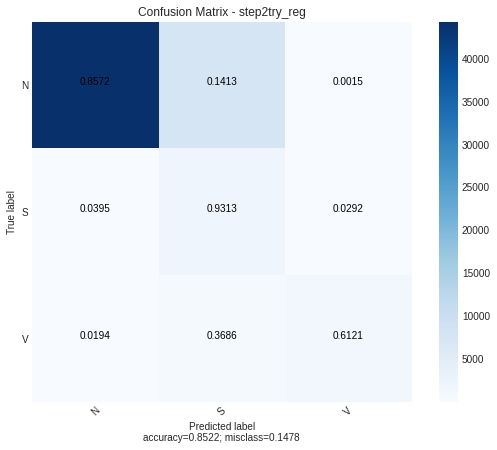

In [ ]:
plot_CMatrix(matrix = matrix,  target_names=['N', 'S', 'V'], normalize = True, title=str("Confusion Matrix - " + str(my_model_name)))
#still more Vs predicted as Ss than desirable but overall satisfying improvement

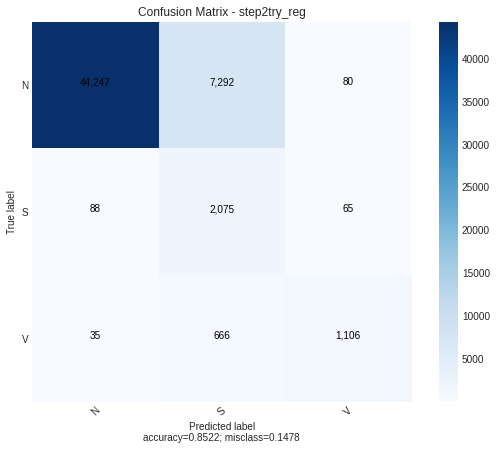

In [ ]:
plot_CMatrix(matrix = matrix,  target_names=['N', 'S', 'V'], normalize = False, title=str("Confusion Matrix - " + str(my_model_name)))

In [ ]:
ht_tot= ht(one_hot_labelsV,prediction) #best (for the classification problem)
ht_tot #notice how this implemented metric is much less optimistic than f1

0.7743612890058452

In [ ]:
f1_tot= sklearn.metrics.f1_score(one_hot_labelsV,prediction, average="samples")

In [ ]:
f1_tot

0.8521939123872498